How to Run Code/ Produce plots
- Run Parts 0 and 1 (imports and define functions)
- Run Part 2 if you want to produce plots 
    - input df_0, df_20, or df_40 along with the temperature value = 0,20 or 40
    - Set evt to true or false depending on which plots you want
        subplots = True: Produce 1 plot for each SOC
        subsubplots = True : Produce 4 plots for each SOC, i.e. 1 for each pulse within the SOC
- Run Part 3 to calculate the parameters

- Part 4 explains how the values are stored - You can just run the code up to Part 4 and ignore the functions before
- Afterwards I go answer the questions one by one in Part 2a, so feel free to add answers/ make modifications there

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
df_0 = pd.read_csv('Data/Model_Training_Data_0.csv')
df_20 = pd.read_csv('Data/Model_Training_Data_20.csv')
df_40 = pd.read_csv('Data/Model_Training_Data_40.csv')
df_0.columns = ["Time", "Current", "Voltage"]
df_20.columns = ["Time", "Current", "Voltage"]
df_40.columns = ["Time", "Current", "Voltage"]

# Create a Current_Change column
df_40["Current_Change"] = df_40["Current"].diff().astype('float64')
df_20["Current_Change"] = df_20["Current"].diff().astype('float64')
df_0["Current_Change"] = df_0["Current"].diff().astype('float64')
# Create a new column Prev_Current which is the previous current
df_40["Prev_Current"] = df_40["Current"].shift(1).astype('float64')
df_20["Prev_Current"] = df_20["Current"].shift(1).astype('float64')
df_0["Prev_Current"] = df_0["Current"].shift(1).astype('float64')
# Create a voltage change column
df_40["Voltage_Change"] = df_40["Voltage"].diff().astype('float64')
df_20["Voltage_Change"] = df_20["Voltage"].diff().astype('float64')
df_0["Voltage_Change"] = df_0["Voltage"].diff().astype('float64')
# Create a new column Prev_Voltage which is the previous voltage
df_40["Prev_Voltage"] = df_40["Voltage"].shift(1).astype('float64')
df_20["Prev_Voltage"] = df_20["Voltage"].shift(1).astype('float64')
df_0["Prev_Voltage"] = df_0["Voltage"].shift(1).astype('float64')

# Creat a rolling sum of the 10 past voltage changes
df_40["Rolling_Voltage_Change"] = df_40["Voltage_Change"].rolling(3).sum().astype('float64')
df_20["Rolling_Voltage_Change"] = df_20["Voltage_Change"].rolling(3).sum().astype('float64')
df_0["Rolling_Voltage_Change"] = df_0["Voltage_Change"].rolling(3).sum().astype('float64')


df_40.fillna(0, inplace=True)
df_20.fillna(0, inplace=True)
df_0.fillna(0, inplace=True)



 # 1. Define functions

#### Function to get subsection

In [3]:
""" One dataset includes charge and discharge sets at 9 different SOCs
This function takes one dataset, and returns a list of the indices correponding 
to the start and end of each SOC. 
The split is done by starting the index after the steady discharge that reduces SOC by 10%,
and ending the index once the 4 charge/discharge pulse at a given SOC is complete.
"""
def get_subsections(df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage

    subsections = []
    start_idx = None
    end_idx = None
    is_subsection = False

    # Get the start and end of each SOC
    # loop over the signal
    for i in range(len(time)):
        # check if current is negative and subsection is not ongoing
        if current[i] < 0 and not is_subsection:
            start_idx = i
            is_subsection = True
        # check if current is zero and subsection is ongoing
        elif current[i] == 0 and is_subsection:
            # check if zero current has persisted for at least 5000 seconds
            if time[i] - time[start_idx] >= 5000:
                # check if current has taken on at least 4 unique positive values since start of subsection
                if len(np.unique(current[start_idx:i])) >= 4:
                    end_idx = i
                    subsections.append((int(start_idx*99.9/100), end_idx))
                    is_subsection = False


    # cout the number of negative values in each subsection in the current signal. If this value is above 1000 remove the subsection from the list
    new_subsections = []
    for i in range(len(subsections)):
        start_idx, end_idx = subsections[i]
        if (len(np.where(current[start_idx:end_idx] < 0)[0]) < 1000):
            new_subsections.append(subsections[i])


    if temp == 0:
        new_subsections.append((410000,460000))
        new_subsections.append((474000,513015))
        new_subsections[-3] = (new_subsections[-3][0], int(new_subsections[-3][1]*1.02))

    return new_subsections

#### Function to plot subsections

In [4]:
"""" This function takes the output of the above get_subsections function
and plots the I-t and V-t graphs with appropriate titles and labels
"""
# Plot time vs current and time vs voltage for each subsection
def plot_subsections(subsections,df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage
    for i, subsection in enumerate(subsections):
        start_idx, end_idx = subsection
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        ax[0].plot(time[start_idx:end_idx], current[start_idx:end_idx])
        ax[0].set_title('Current vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "%")
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Current (A)')
        ax[0].grid(True)
        ax[1].plot(time[start_idx:end_idx], voltage[start_idx:end_idx])
        ax[1].set_title('Voltage vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "%")
        ax[1].set_xlabel('Time (s)')
        ax[1].set_ylabel('Voltage (V)')
        ax[1].grid(True)
        plt.subplots_adjust(hspace=0.25)
        fig.subplots_adjust(hspace=0.4)

#### Function to get subsubsections

In [5]:
""" This function takes the start and end of each test at a single SOC, and
returns start and end indices corresponding to each charge/discharge pulse
Each SOC has 4 charge/discharge pulses, so the output is a list of 4 tuples
"""
def get_subsubsections(subsections,df, offset=500):
    subsubs = []
    for sub in subsections:
        df_new = df[sub[0]:sub[1]]
        df_ind = df_new[df_new.Current_Change < -0.1]
        indices = df_ind.index.to_list()
        subsubs.append([(indices[i*2]-offset, indices[i*2+1]+offset) for i in range(len(indices)//2)])
    return subsubs

#### Functoin to plot subsubsections

In [6]:
""" This function receives the indices of individual pulses in the dataset from the above
function and plots the I-t and V-t graphs for each charge/discharge pulse

"""
# Plot time vs current and time vs voltage for each subsection
def plot_subsubsections(subsections,df,temp):
    time = df.Time
    current = df.Current
    voltage = df.Voltage

    for i in range(len(subsections)):
        current_subsections = subsections[i]
        for k in range(len(current_subsections)):
            start_idx, end_idx = current_subsections[k]
            fig, ax = plt.subplots(2, 1, figsize=(10, 6))
            ax[0].plot(time[start_idx:end_idx], current[start_idx:end_idx])
            ax[0].set_title(f'Current vs Time for Temp {temp} SOC ' + str(90 - 10*i) + "% Pulse #" + str(k+1))
            ax[0].set_xlabel('Time (s)')
            ax[0].set_ylabel('Current (A)')
            ax[0].grid(True)
            ax[1].plot(time[start_idx:end_idx], voltage[start_idx:end_idx])
            ax[1].set_title(f'Voltage vs Time for Temp {temp} SOC' + str(90 - 10*i) + "% Pulse #" + str(k+1))
            ax[1].set_xlabel('Time (s)')
            ax[1].set_ylabel('Voltage (V)')
            ax[1].grid(True)
            plt.subplots_adjust(hspace=0.25)
            fig.subplots_adjust(hspace=0.4)

##### Overall Plotting function

In [7]:
""" This function plots graphs of a given dataset for the whole test, and zoomed in versions for each SOC and Pulse based on
input parameters.
"""
def plot_current_voltage(df, temp, color="g", current = True, voltage =True, overall_plot=True, subplots = True, subsubplots = True):
    
    if overall_plot:
        fig, ax = plt.subplots(2, 1, figsize=(18, 12))
        if current:
            ax[0].plot(df.Time, df.Current, c=color)
            ax[0].set_title('Current vs Time at Temperature: ' + str(temp) + 'C')
            ax[0].set_xlabel('Time (s)')
            ax[0].set_ylabel('Current (A)')
            ax[0].grid(True)
            ax[0].set_xticks(np.linspace(0, df['Time'].max(), 40))
            ax[0].tick_params(axis='x', rotation=90)

        if voltage:
            ax[1].plot(df.Time, df.Voltage,c=color)
            ax[1].set_title('Voltage vs Time at Temperature: ' + str(temp) + 'C')
            ax[1].set_xlabel('Time (s)')
            ax[1].set_ylabel('Voltage (V)')
            ax[1].grid(True)
            ax[1].set_xticks(np.linspace(0, df['Time'].max(), 40))
            ax[1].tick_params(axis='x', rotation=90)

        plt.subplots_adjust(hspace=0.25)


    subsections = get_subsections(df,temp)

    if subplots:
        plot_subsections(subsections,df,temp)

    subsubsections  = get_subsubsections(subsections, df)
    if subsubplots:
        plot_subsubsections(subsubsections, df,temp)


    return subsubsections
        


# 2. Plotting

C:\Users\feyzi\AppData\Local\Temp\ipykernel_26896\2541108275.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(10, 6))


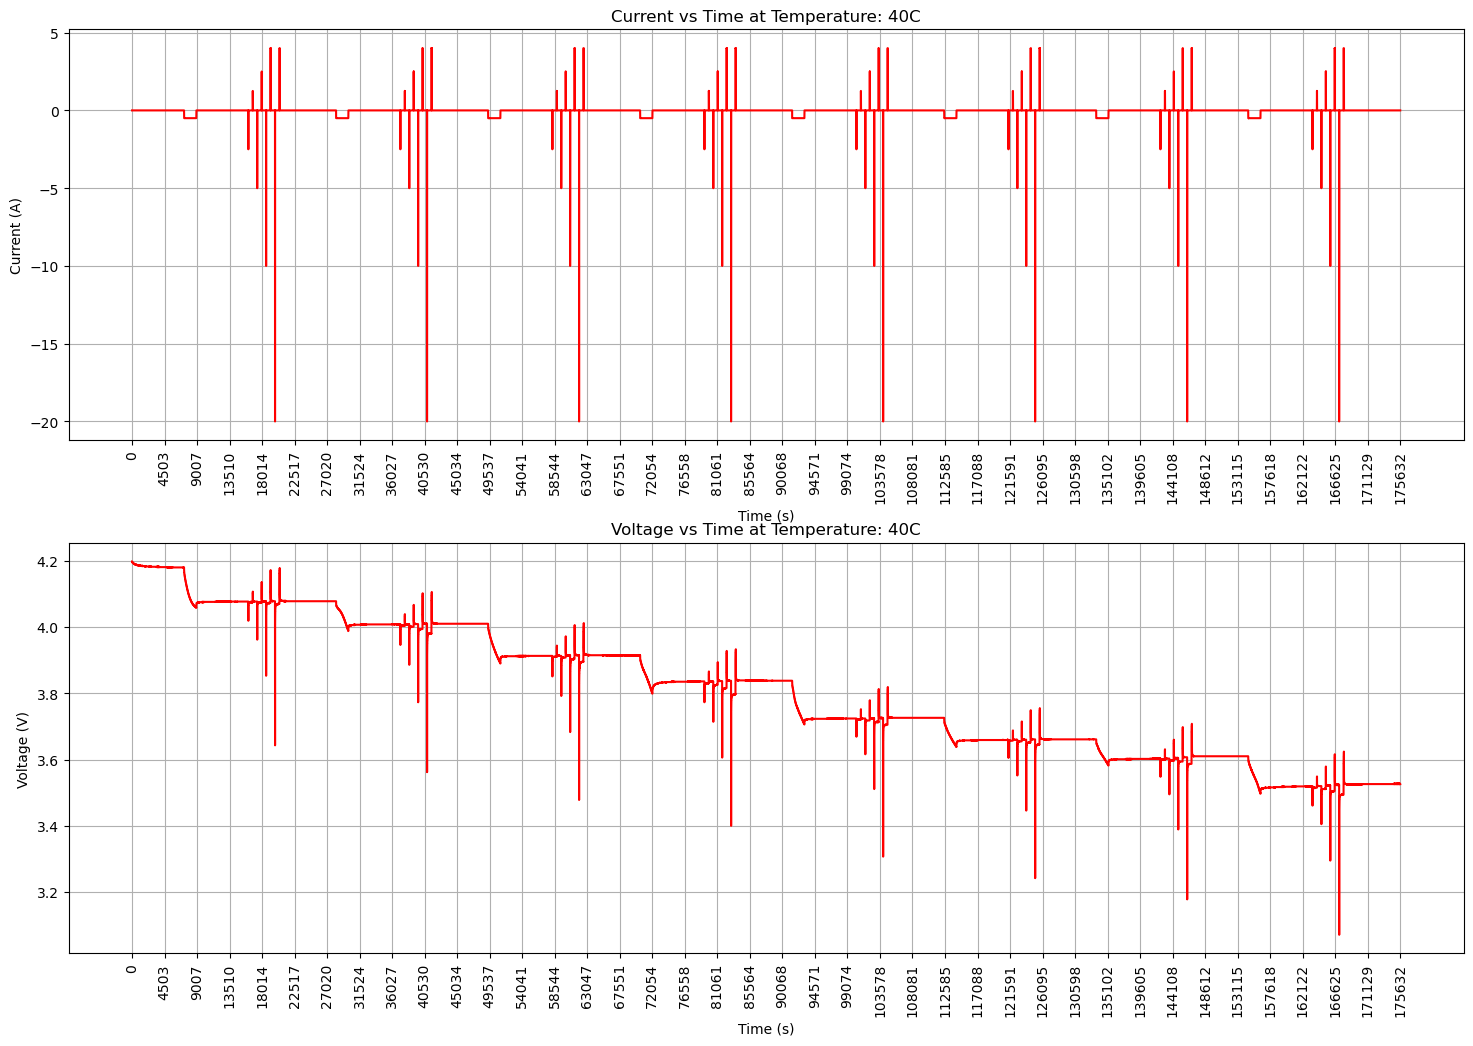

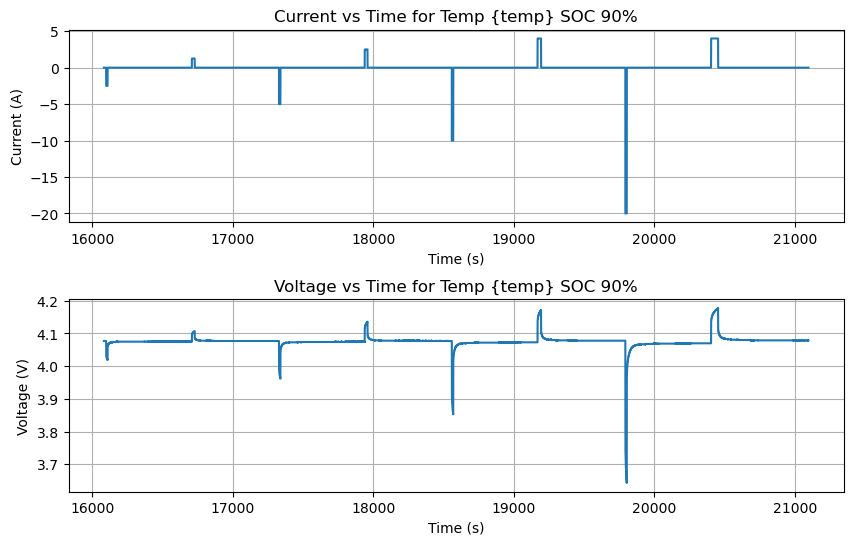

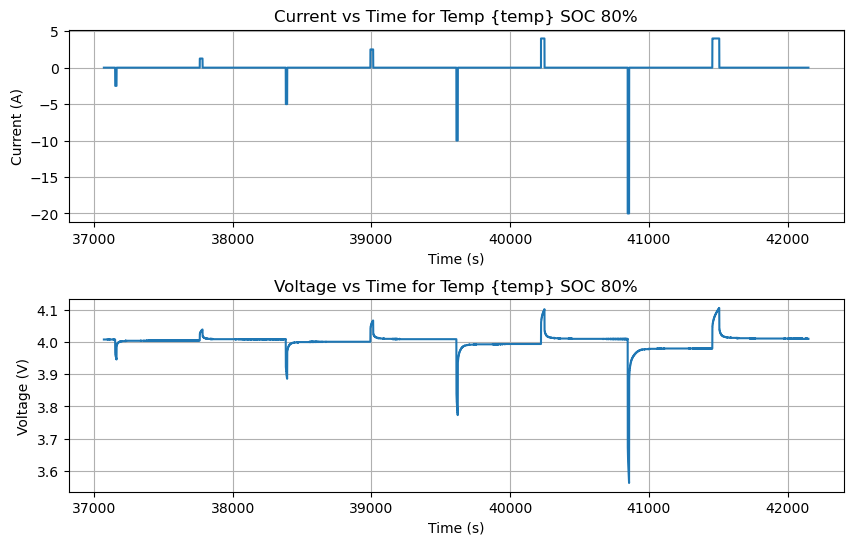

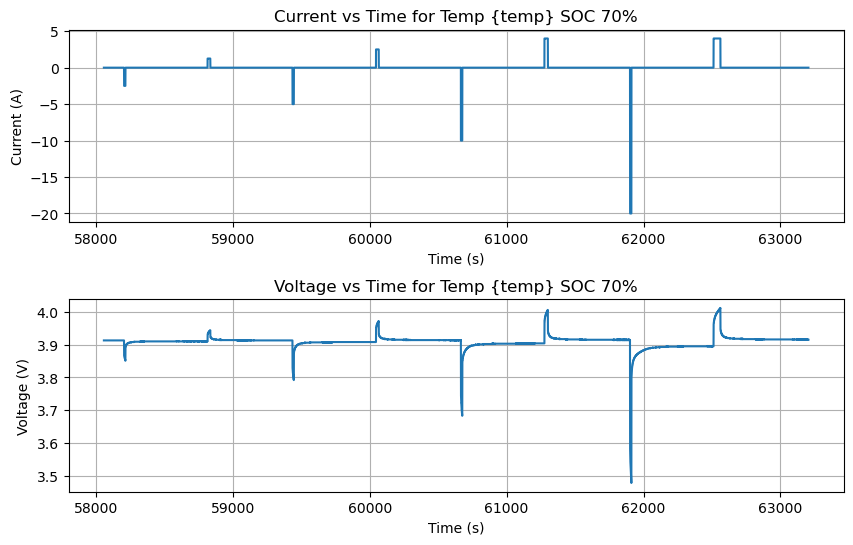

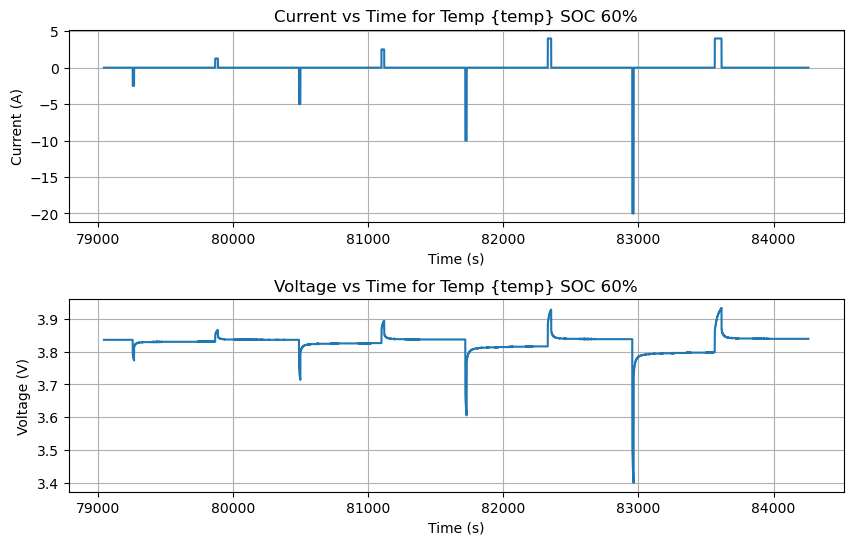

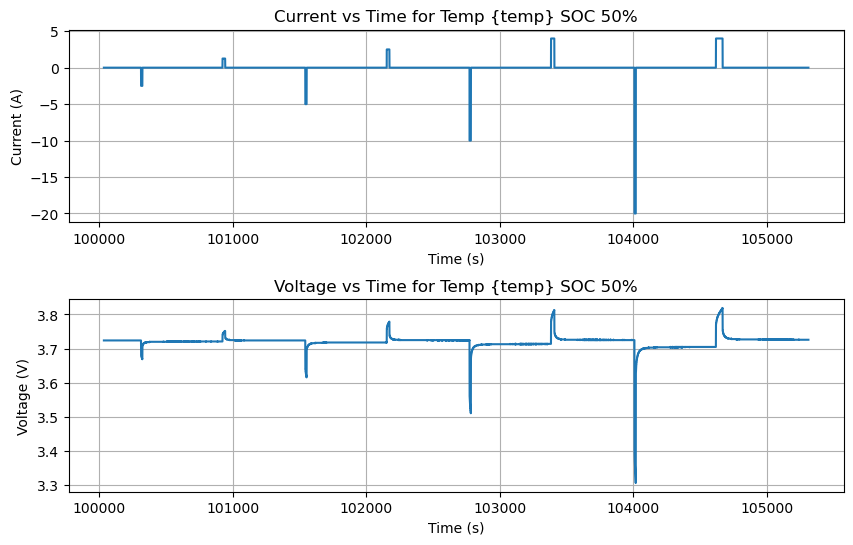

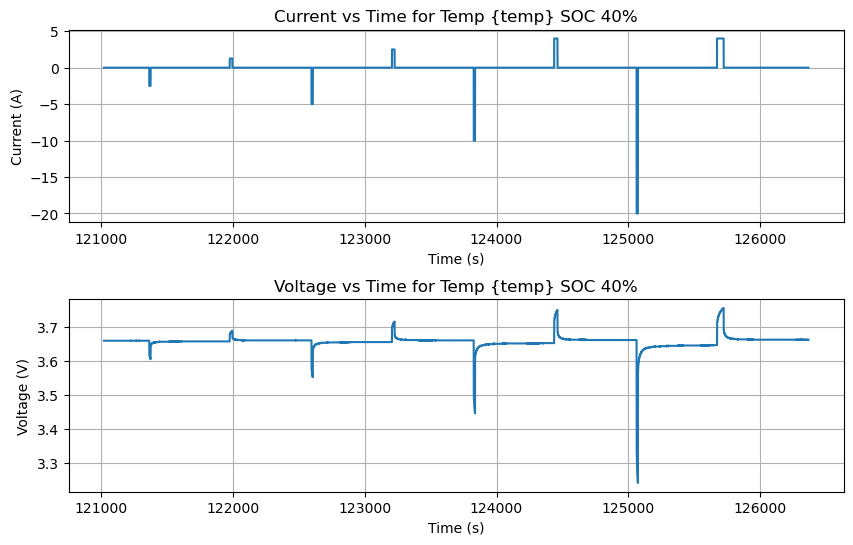

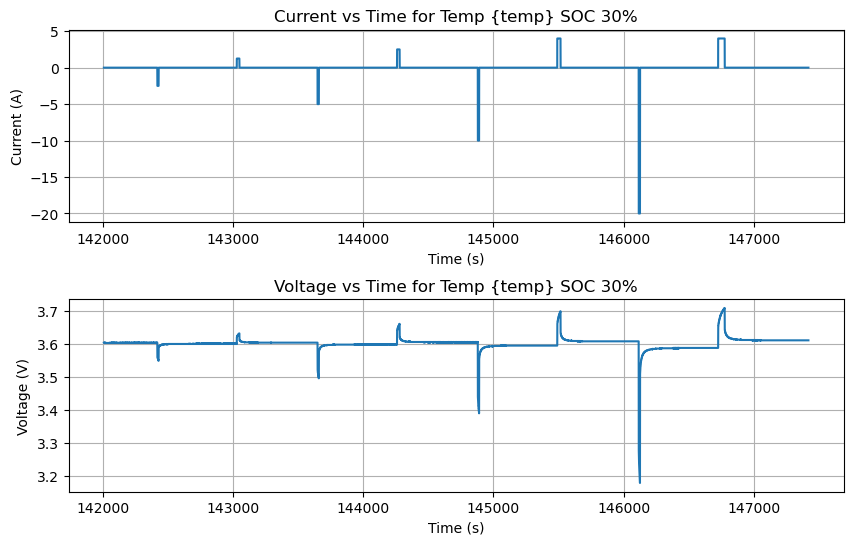

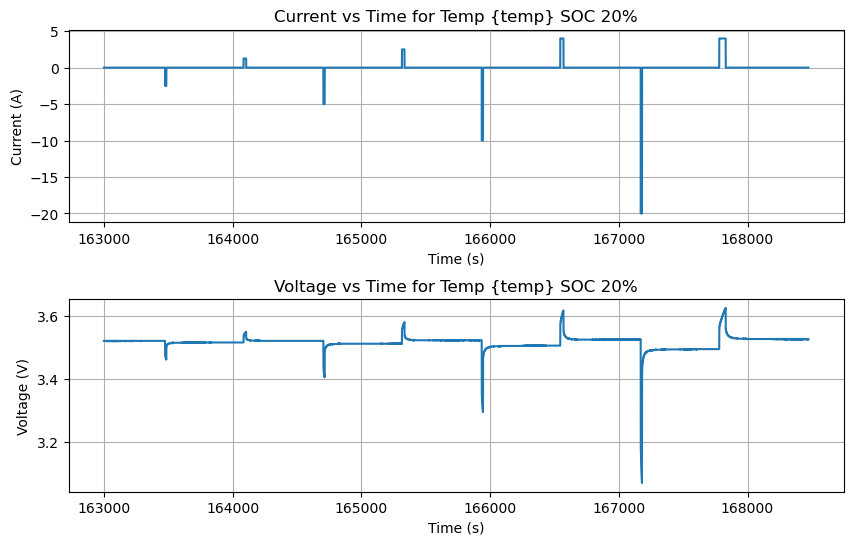

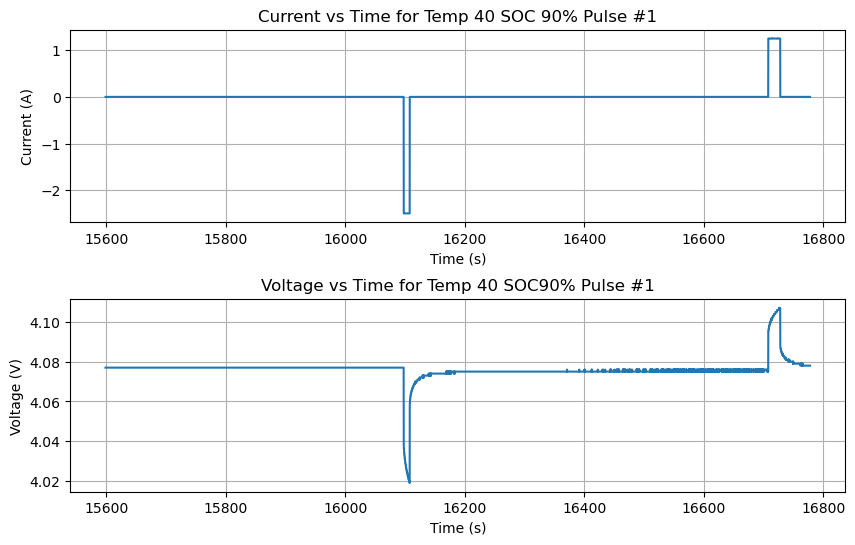

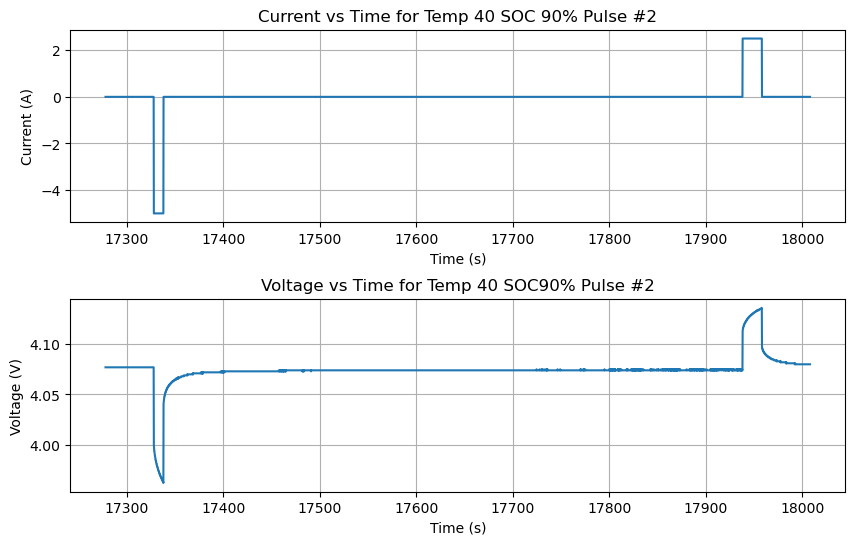

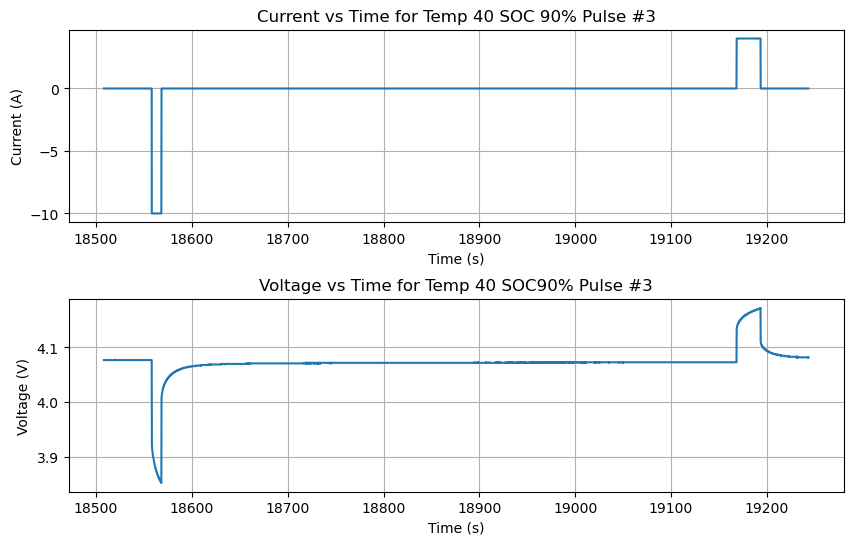

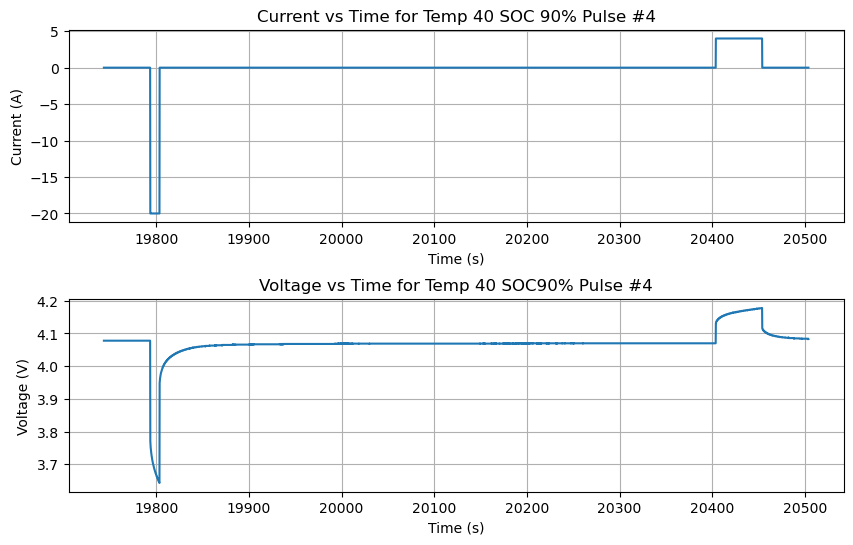

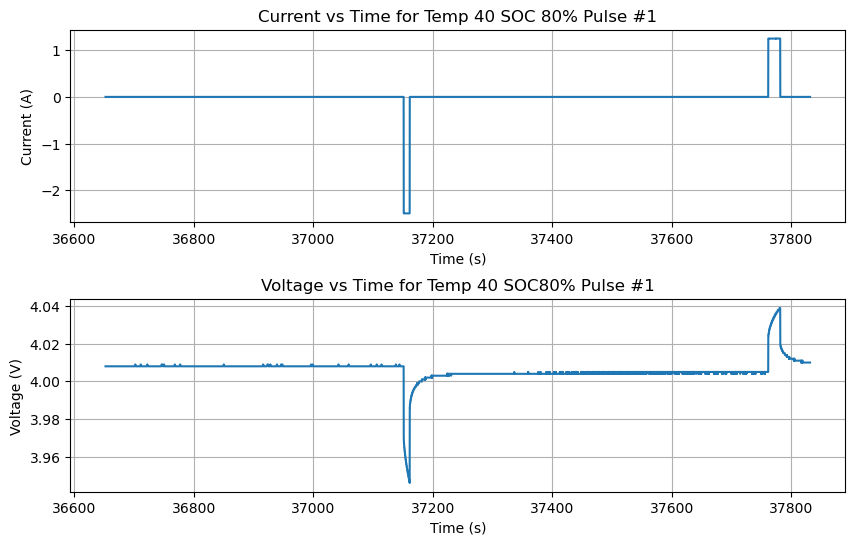

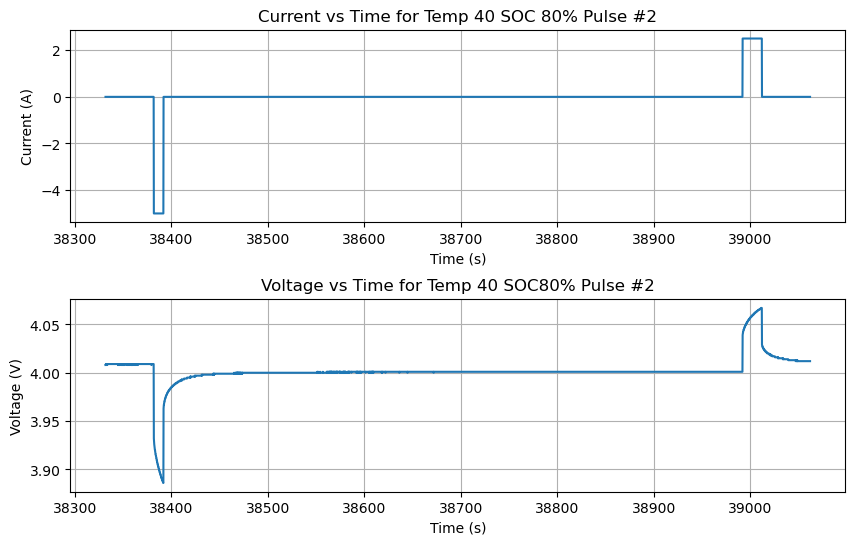

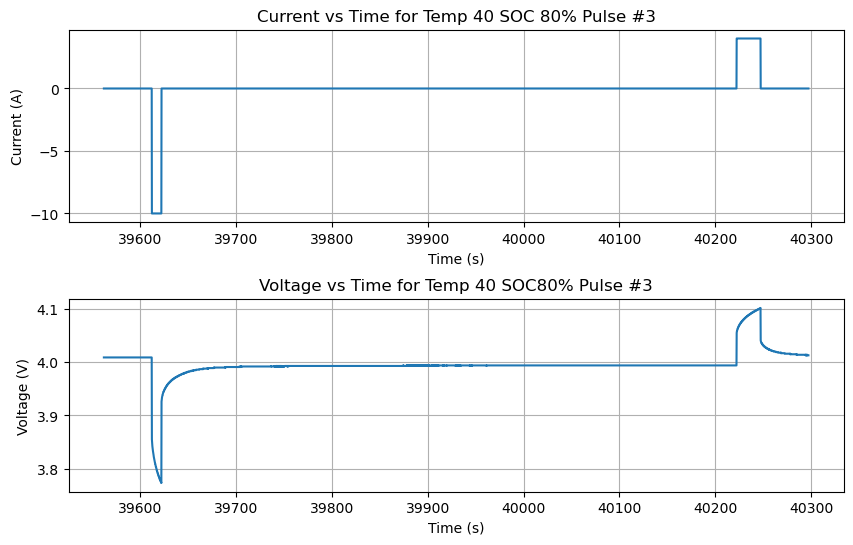

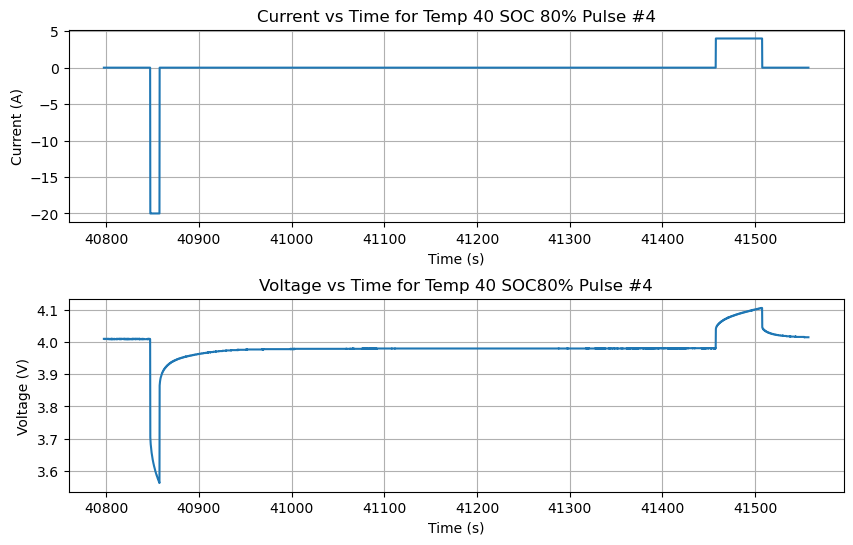

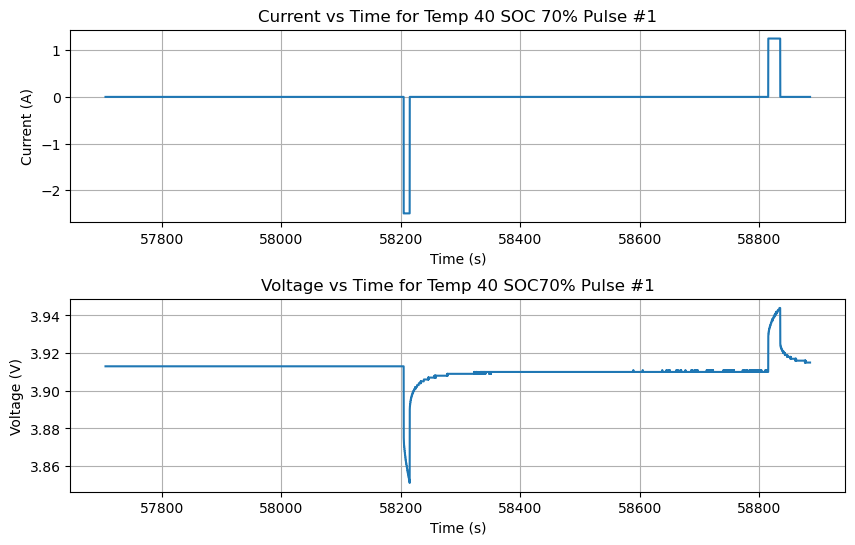

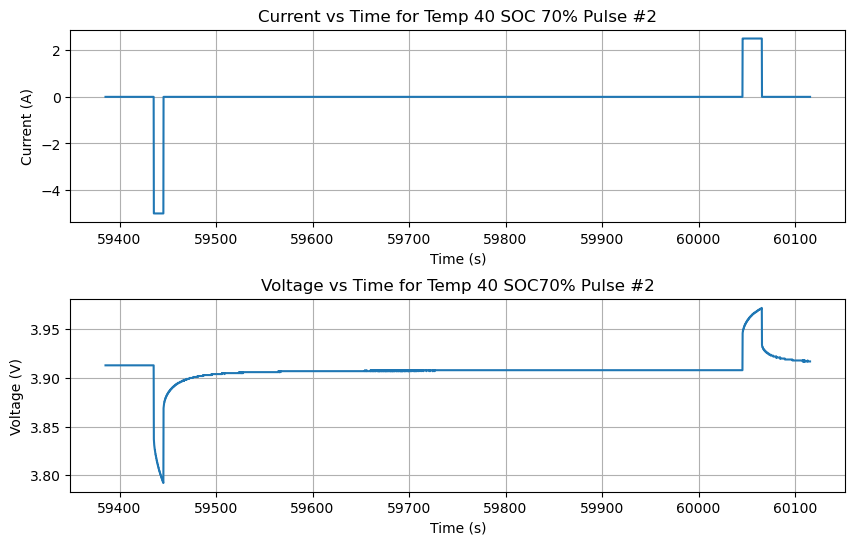

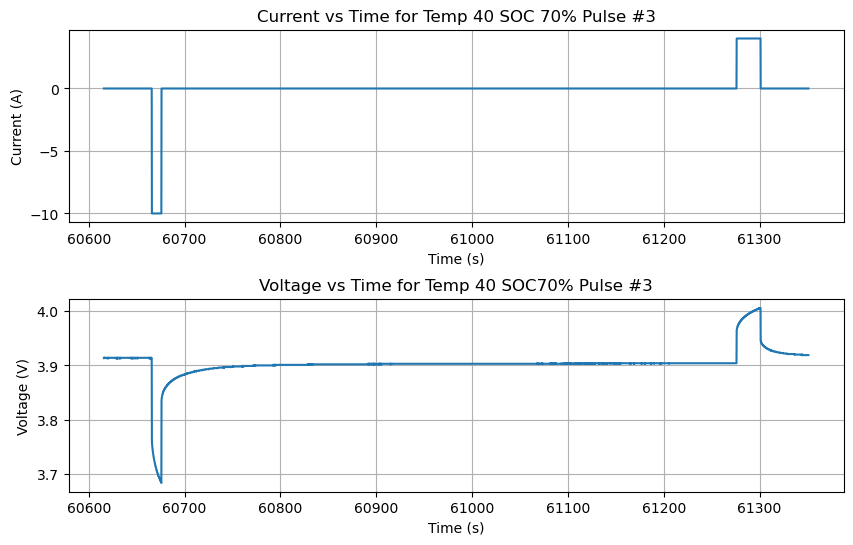

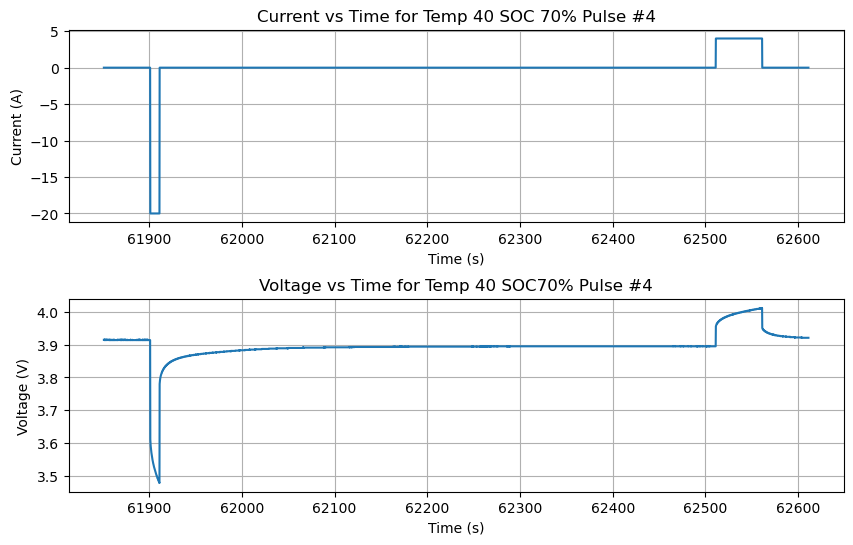

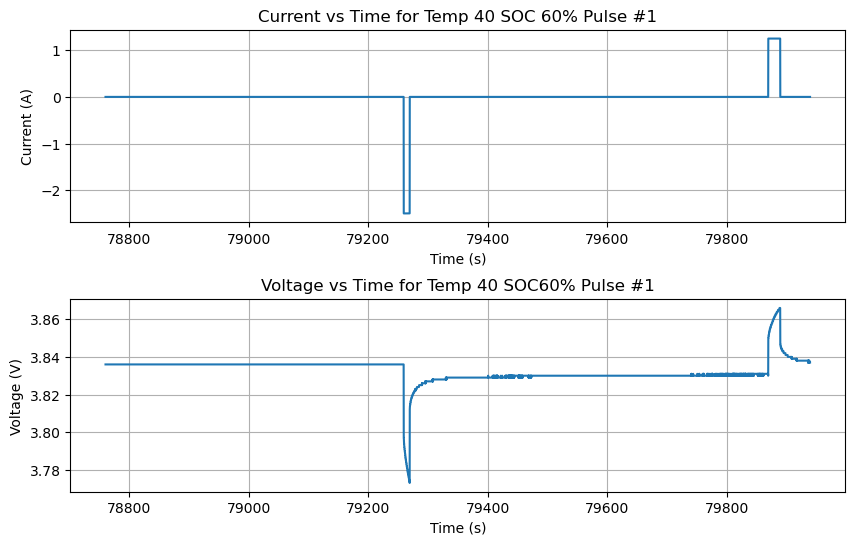

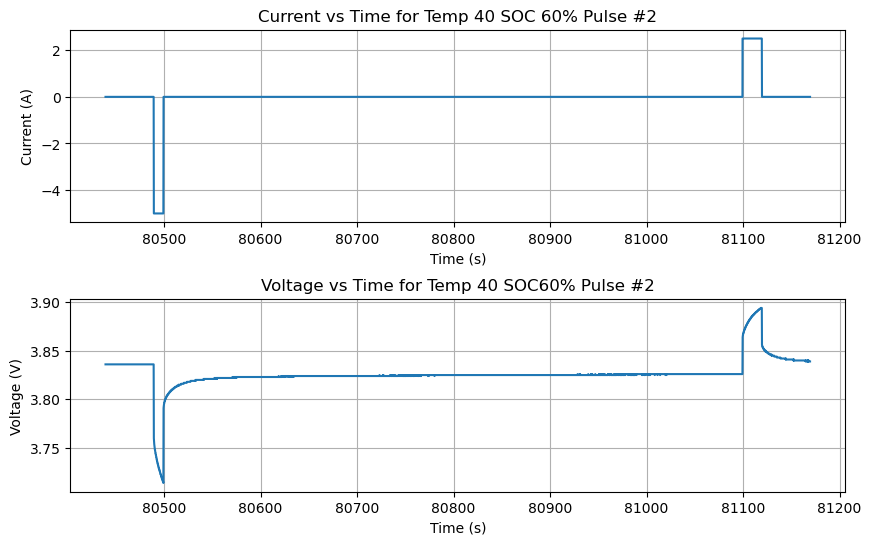

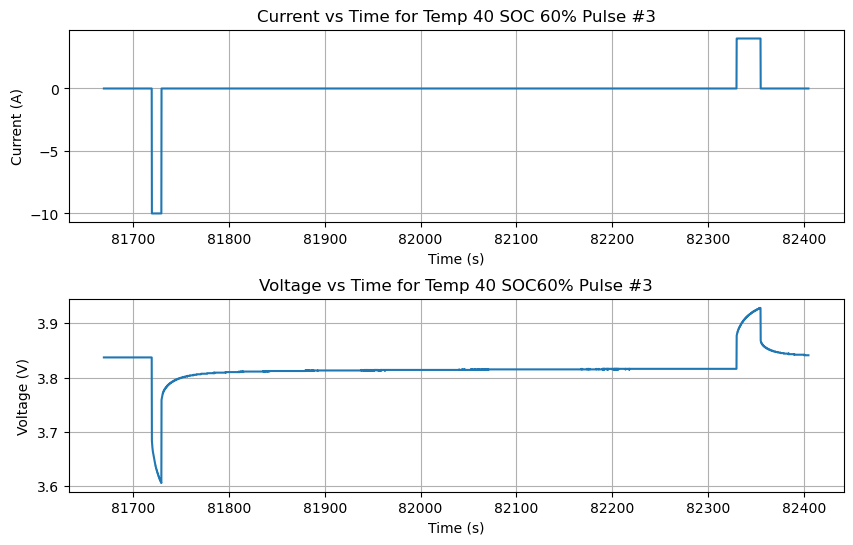

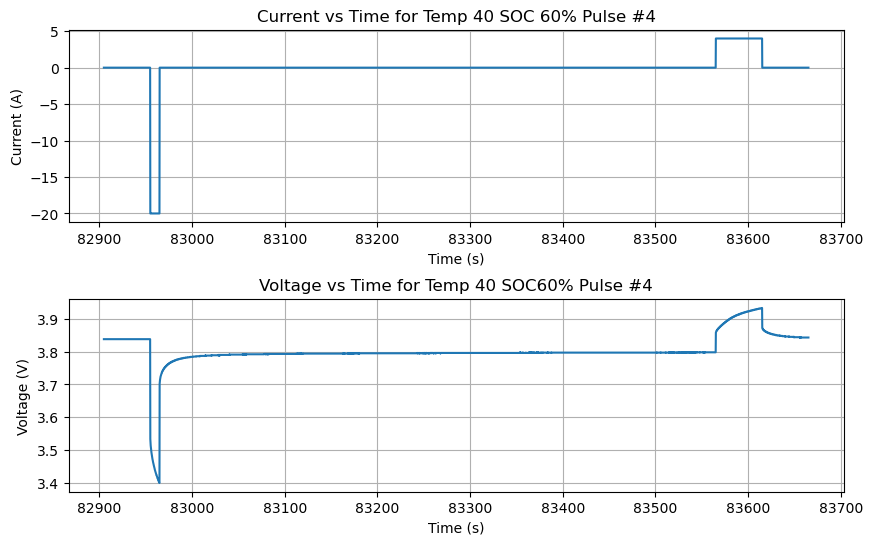

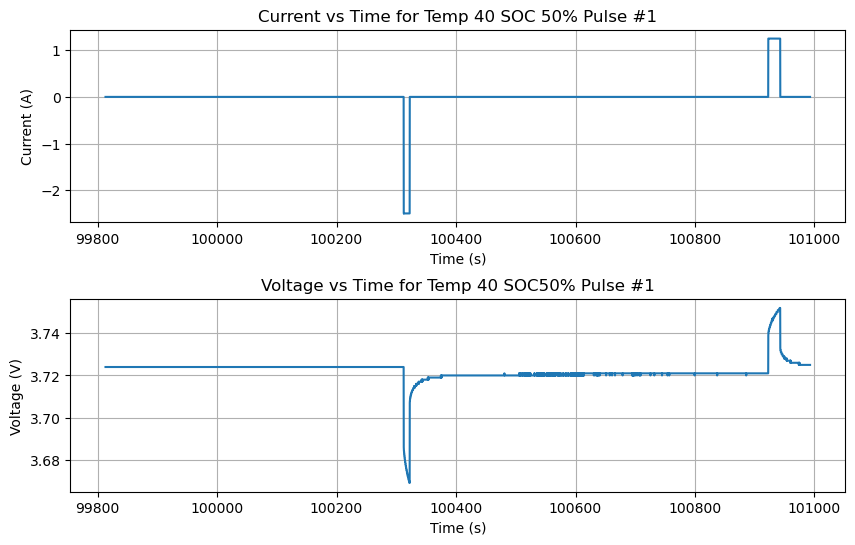

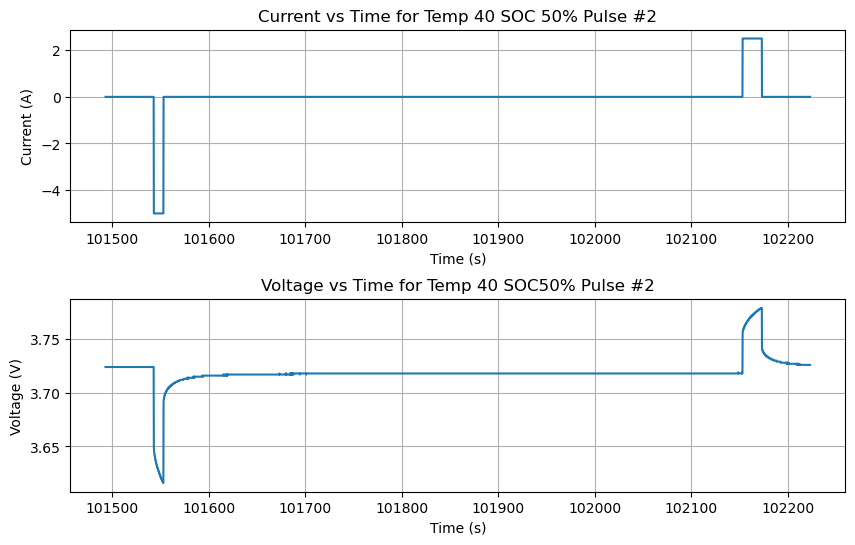

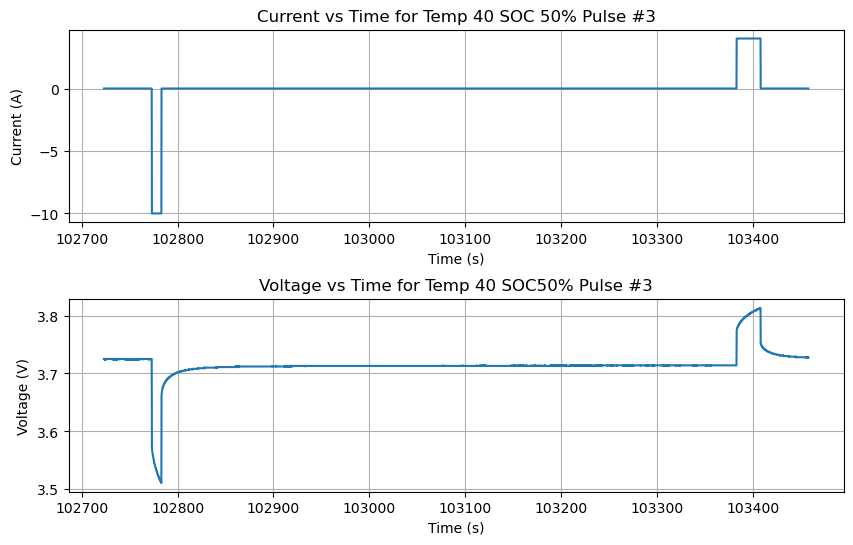

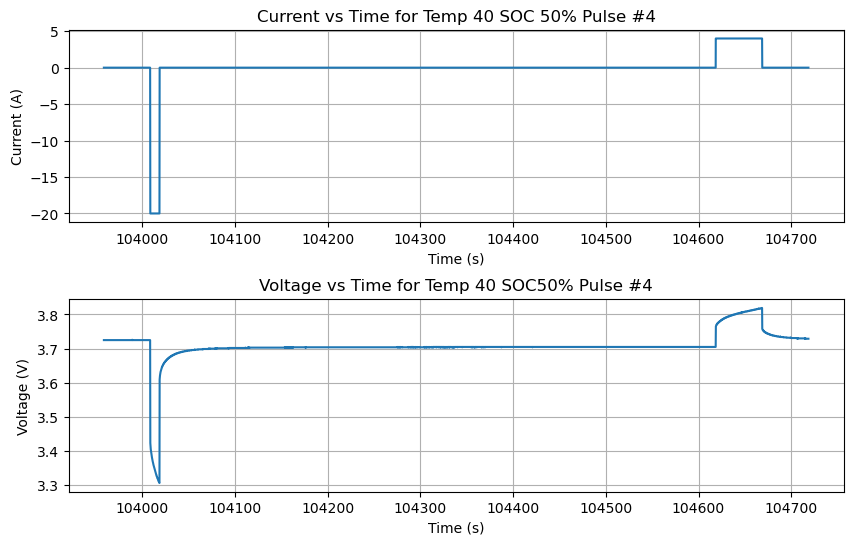

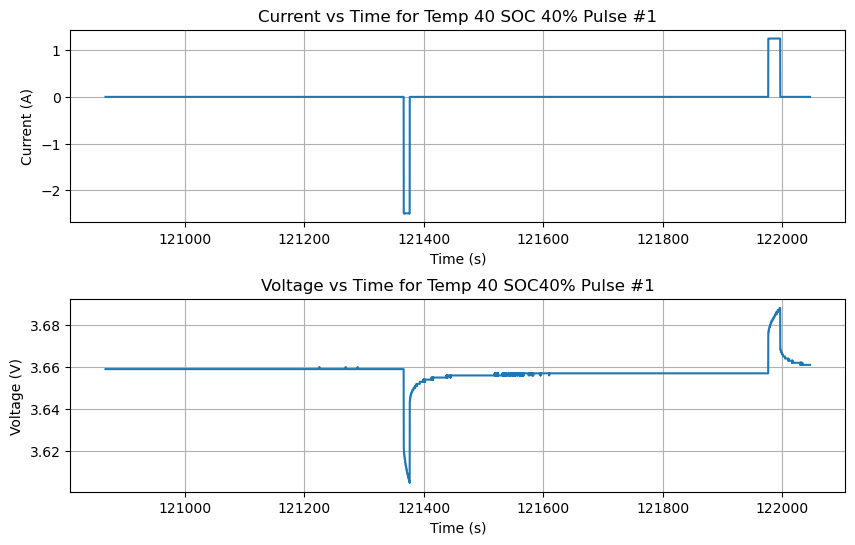

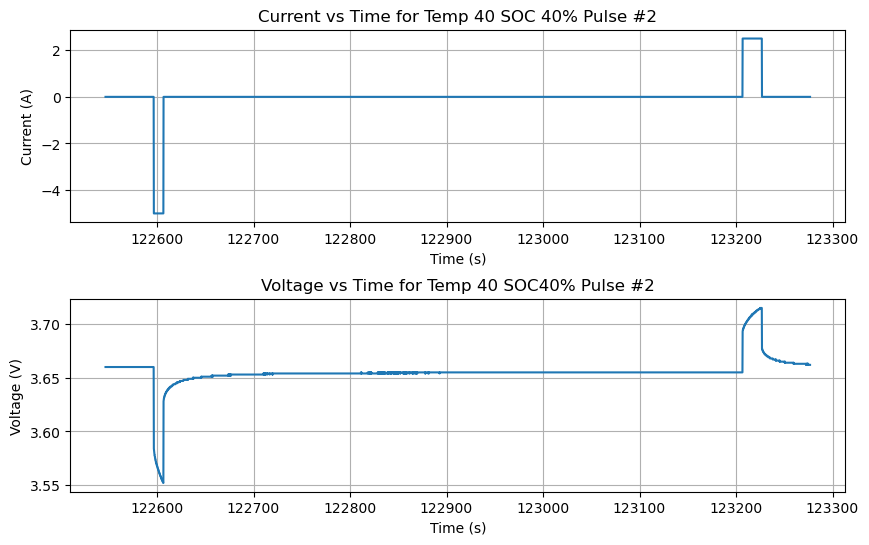

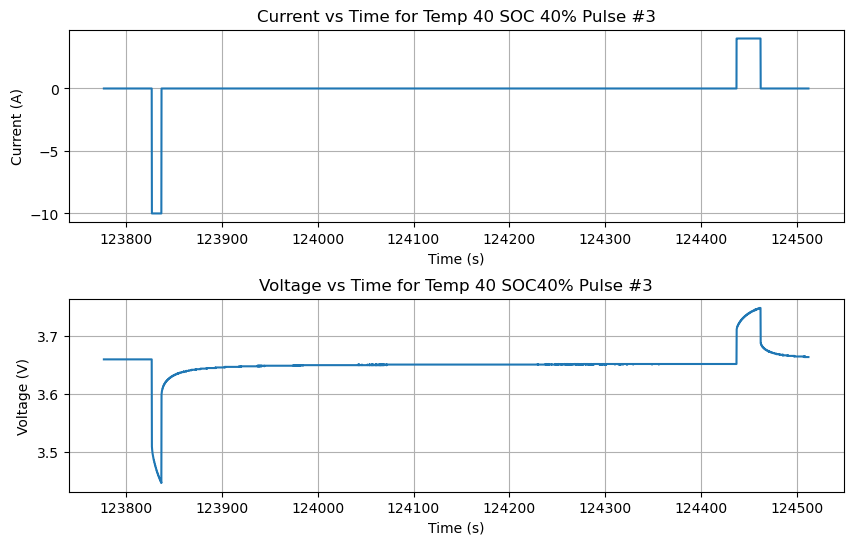

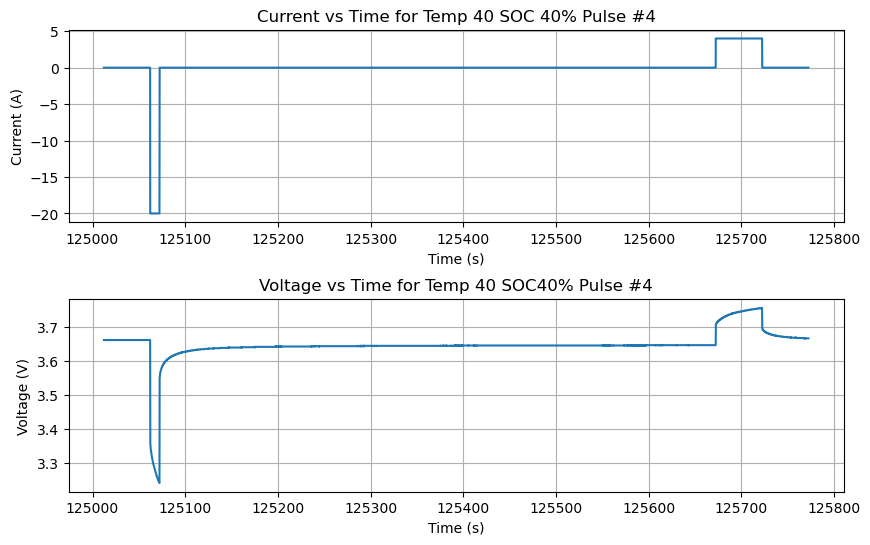

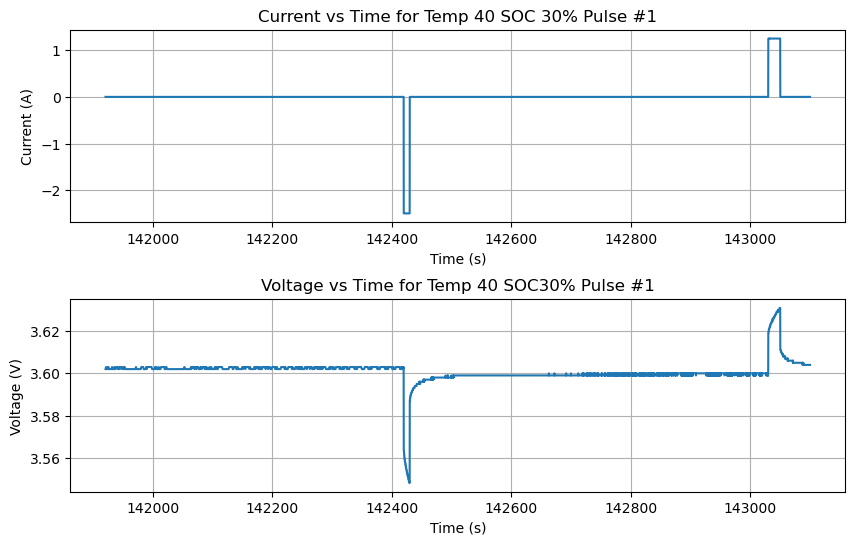

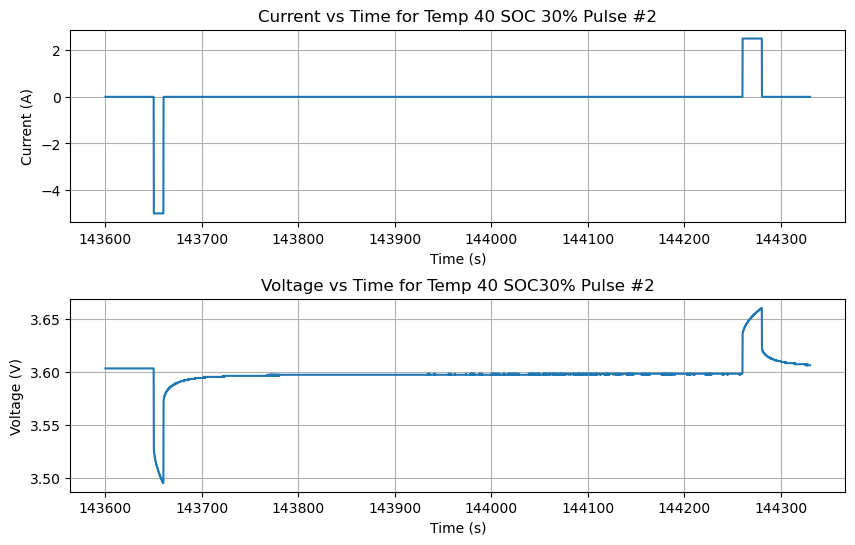

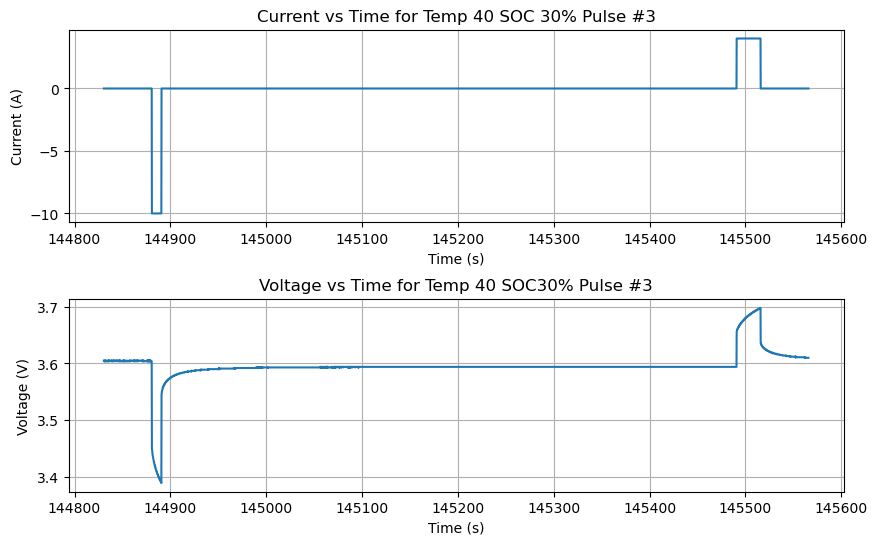

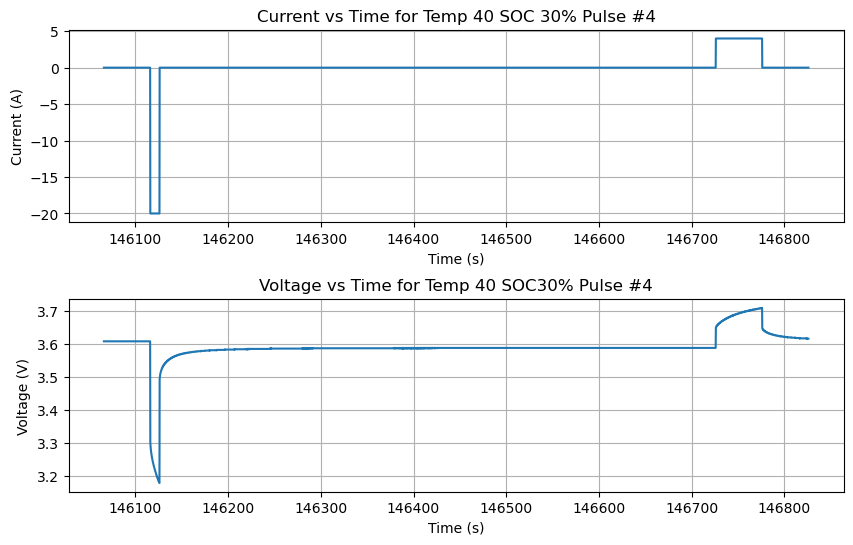

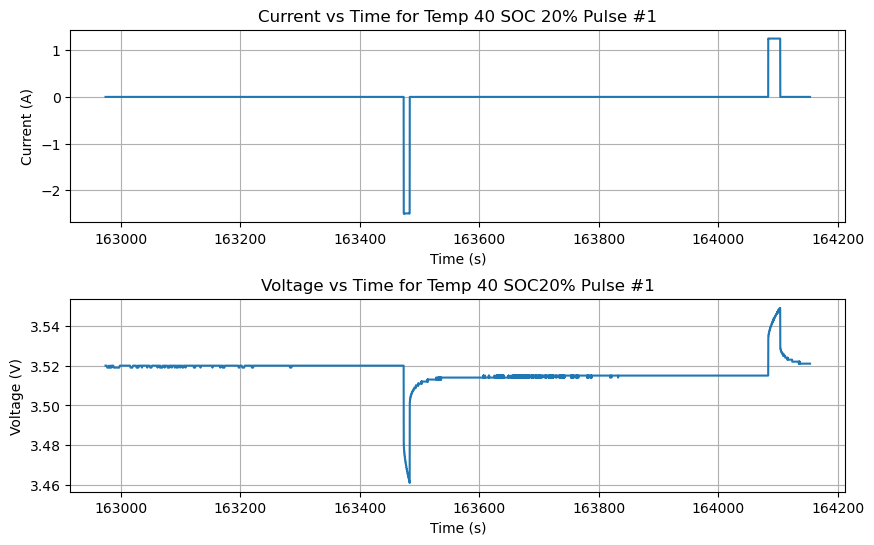

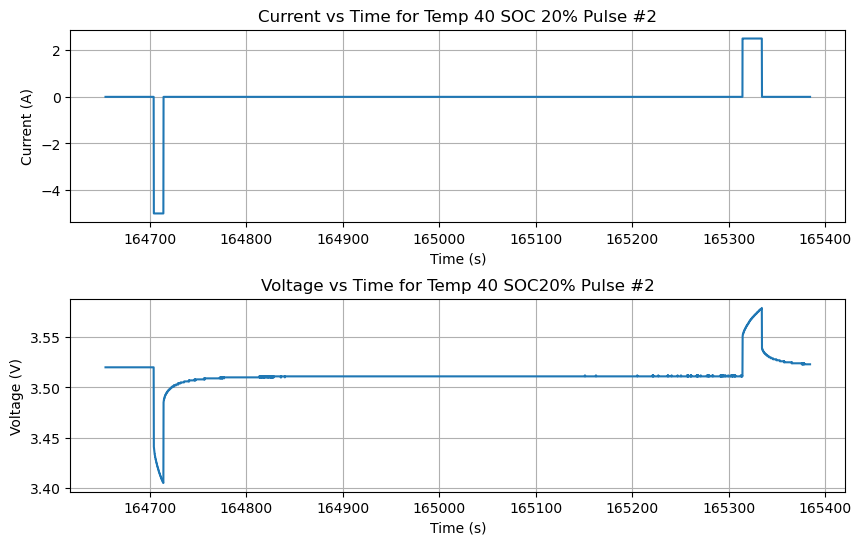

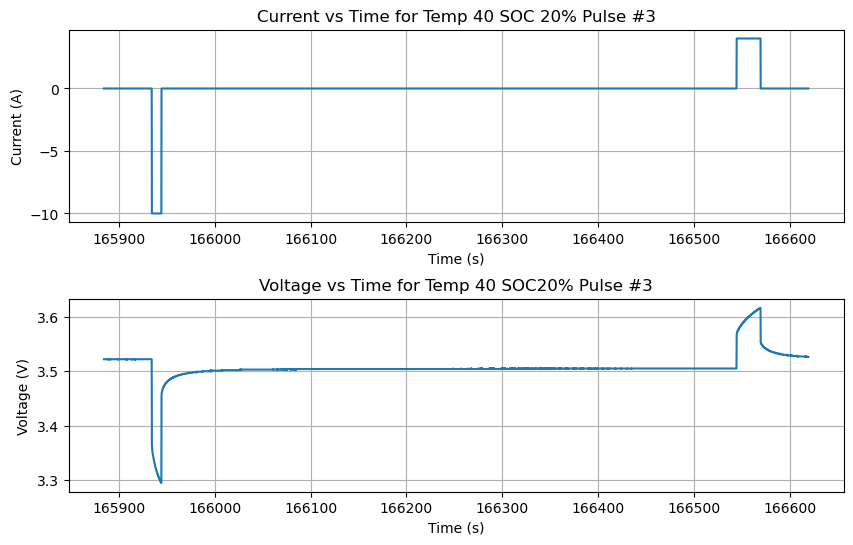

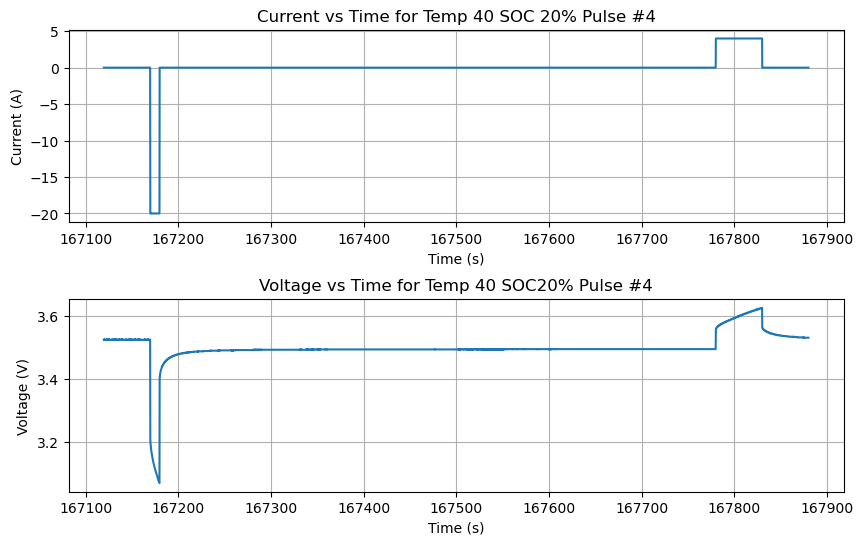

In [8]:
my_subs = plot_current_voltage(df_40, 40, color="r", subplots = True, subsubplots = True)

Need a way to automatically get the time indexes of the beginning of each charge and discharge cycle, as well as each soc


# 3. Calculating Parameters

Here I use the above functions to get a 3D matrix, where each element stores the start and end of an individual charge discharge test.
Dimensions are ordered as Temperature-SOC-Pulse, hence it is a 3-8-4 matrix

In [9]:
""" sub_matrix_0 = get_subsubsections(get_subsections(df_0,0),df_0)
sub_matrix_20 = get_subsubsections(get_subsections(df_20,20),df_20)
sub_matrix_40 = get_subsubsections(get_subsections(df_40,40),df_40)
del sub_matrix_0[-2] # handle extra row that's there for whatever reason
sub_matrices = [sub_matrix_0, sub_matrix_20, sub_matrix_40] 
# save sub_matrices to pickle file
import pickle
with open('sub_matrices.pkl', 'wb') as f:
    pickle.dump(sub_matrices, f) """


" sub_matrix_0 = get_subsubsections(get_subsections(df_0,0),df_0)\nsub_matrix_20 = get_subsubsections(get_subsections(df_20,20),df_20)\nsub_matrix_40 = get_subsubsections(get_subsections(df_40,40),df_40)\ndel sub_matrix_0[-2] # handle extra row that's there for whatever reason\nsub_matrices = [sub_matrix_0, sub_matrix_20, sub_matrix_40] \n# save sub_matrices to pickle file\nimport pickle\nwith open('sub_matrices.pkl', 'wb') as f:\n    pickle.dump(sub_matrices, f) "

In [10]:
# load sub_matrices from pickle file
import pickle
with open('sub_matrices.pkl', 'rb') as f:
    sub_matrices = pickle.load(f)

I go through the matrix, extracting the instantaneous change in voltage, settling time, and steady state voltage rise that we need to calculate R0,R1,C1

In [11]:
dfs = [df_0, df_20, df_40]

v_min_vals = np.ndarray((3,8,4))
v_inst_changes = np.ndarray((3,8,4))
v_settling_changes = np.ndarray((3,8,4))
t_settling_times =  np.ndarray((3,8,4))
delta_curr = np.ndarray((3,8,4))
curr = np.ndarray((3,8,4))


for n in range(3):
    df = dfs[n]
    sub_matrix = sub_matrices[n]

    for j in range(len(sub_matrix)): # Loop through each SOC
        for k in range(len(sub_matrix[j])): # Loop through each of the 4 pulses
            start_idx, end_idx = sub_matrix[j][k]
            df_temp = df[start_idx:end_idx]

            # 1. Find the instantanious voltage rise: Just when current rises from -x to 0
            idx = df_temp[(df_temp.Current_Change > 0.1) & (df_temp.Prev_Current < 0) & (df_temp.Voltage_Change > 0)].index.to_list()
            if len(idx) != 1:
                print(f"{n,j,k} has this many instant voltage change points:{len(idx)}" )
            idx = idx[0]
            df_zoom = df[idx-10:idx+10]
            v_change = df_temp.loc[idx,"Voltage_Change"]
            v_inst_changes[n,j,k] = v_change
            delta_curr[n,j,k] = df_temp.loc[idx,"Current_Change"]
            curr[n,j,k] = df_temp.loc[idx,"Prev_Current"]

            idx_v_change = idx # store this index
            
            # 2. Find the total voltage rise - just before the point where current rises from 0 to smt positive
            idx = df_temp[(df_temp.Current_Change > 0.1) & (abs(df_temp.Prev_Current) < 0.01)& (df_temp.Voltage_Change > 0)].index.to_list()
            if len(idx) != 1:
                print(f"{n,j,k} has this many instant voltage change points:{len(idx)}" )
            idx = idx[0] - 5
            df_temp.loc[idx]

            v_settled = df_temp.loc[idx,"Voltage"]
            v_min = df_temp.Voltage.min()
            v_min_vals[n,j,k] = v_min
            v_settling_changes[n,j,k] = v_settled - v_min # store change between minimum and settled voltage

            idx_v_settled = idx # store the index
            
            # 3. Find the settling time - When the voltage is settled for 10 period, equal to steady state voltage, after discharge
            
            #idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage ==  v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            #idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage > 0.99 * v_settled) &  (df_temp.Voltage < 1.001 * v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            
            tolerance = 0.05
            idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage > (1*tolerance) * v_settled) &  (df_temp.Voltage < (1 + tolerance) * v_settled) & (df_temp.Voltage_Change == 0 )].index.to_list()

            #print(n,i,k)
            #if (n,j,k) == (2,4,1): # manually handle exception
            #    idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage > 0.999 * v_settled) &  (df_temp.Voltage < 1.001 * v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            
            idx = idx[0]

            t_settling = df_temp.loc[idx,"Time"] - df_temp.loc[idx_v_change,"Time"]
            t_settling_times[n,j,k] = t_settling

            idx_t_settled = idx # store the index
        


v_inst_changes = np.round(v_inst_changes,3)
v_settling_changes = np.round(v_settling_changes,3)
t_settling_times = np.round(t_settling_times,3)
delta_curr = np.round(delta_curr,3)
curr = np.round(curr,3)


Handle outliers by filling with average or known values

In [12]:
v_inst_changes[0,7,3] = v_inst_changes[0,:-1,3].mean()
# do the same for the other matrices
v_settling_changes[0,7,3] = v_settling_changes[0,:-1,3].mean()
t_settling_times[0,6,3] = t_settling_times[0,:-2,3].mean()
t_settling_times[0,7,3] = t_settling_times[0,:-1,3].mean()
delta_curr[0,7,3] = 20 # handle exception
curr[0,7,3] = -20

Plot settling times

#### Calculating R0,R1,C1 values

We have the required data in the matrix above so I calculate them using the below approahc

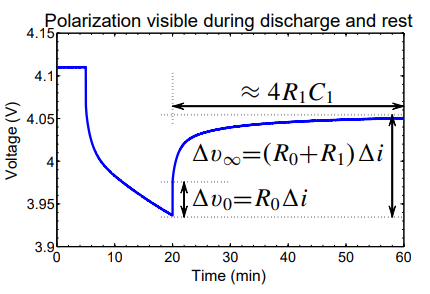

In [13]:
# create empty arrays
R0_matrix = np.ndarray((3,8,4))
R1_matrix = np.ndarray((3,8,4))
C1_matrix = np.ndarray((3,8,4))

# fill them with the formula
R0_matrix = v_inst_changes / delta_curr
R1_matrix = v_settling_changes / delta_curr - R0_matrix
R1_matrix[0,7,3] = 0.1 # handle missing value
C1_matrix = t_settling_times /4 / R1_matrix
C1_matrix = np.round(C1_matrix,3)

Save data

In [14]:
np.save("r0.npy",R0_matrix)
np.save("r1.npy",R1_matrix)
np.save("c1.npy",C1_matrix)

In [15]:
t_settling_times

array([[[0.5 , 1.  , 1.9 , 3.8 ],
        [0.7 , 0.9 , 1.5 , 3.9 ],
        [0.5 , 0.9 , 1.5 , 3.9 ],
        [0.6 , 0.8 , 1.6 , 3.9 ],
        [0.5 , 0.9 , 1.4 , 3.6 ],
        [0.5 , 0.8 , 1.6 , 4.  ],
        [0.7 , 1.  , 2.3 , 3.85],
        [1.2 , 1.9 , 3.2 , 3.85]],

       [[0.1 , 0.1 , 0.1 , 0.2 ],
        [0.1 , 0.1 , 0.1 , 0.2 ],
        [0.1 , 0.2 , 0.2 , 0.2 ],
        [0.1 , 0.1 , 0.1 , 0.1 ],
        [0.1 , 0.1 , 0.1 , 0.1 ],
        [0.1 , 0.2 , 0.1 , 0.1 ],
        [0.2 , 0.2 , 0.1 , 0.2 ],
        [0.1 , 0.1 , 0.1 , 0.3 ]],

       [[0.1 , 0.7 , 1.5 , 2.2 ],
        [0.2 , 0.5 , 1.  , 1.6 ],
        [0.3 , 0.6 , 1.  , 2.1 ],
        [0.3 , 0.3 , 1.  , 2.  ],
        [0.3 , 0.4 , 1.  , 1.8 ],
        [0.1 , 0.4 , 0.8 , 2.2 ],
        [0.2 , 0.4 , 0.6 , 2.1 ],
        [0.1 , 0.4 , 0.8 , 2.4 ]]])

In [16]:
C1_matrix

array([[[  6.939,  15.06 ,  33.213,  77.551],
        [  9.305,  13.554,  26.786,  82.975],
        [  6.646,  13.554,  27.568,  86.279],
        [  9.864,  15.148,  34.483,  90.693],
        [  9.184,  17.304,  28.689,  76.919],
        [  8.929,  14.487,  29.624,  74.07 ],
        [  9.305,  13.155,  30.908,  42.969],
        [  9.486,  15.83 ,  27.775,   9.625]],

       [[  3.125,   2.5  ,   2.778,   6.25 ],
        [  2.083,   2.5  ,   2.778,   6.667],
        [  2.083,   4.167,   5.556,   6.667],
        [  2.083,   3.125,   3.571,   4.167],
        [  3.125,   3.125,   4.167,   4.167],
        [  3.125,   6.25 ,   3.571,   3.846],
        [  6.25 ,   6.25 ,   4.167,   7.692],
        [  3.125,   3.125,   3.571,   9.375]],

       [[  3.675,  24.99 ,  55.142,  85.267],
        [  6.245,  16.026,  35.208,  66.112],
        [  8.921,  18.75 ,  35.208,  87.496],
        [  9.367,  10.417,  41.658,  98.039],
        [ 12.495,  17.854,  47.165,  89.995],
        [  4.464,  17.85 ,  36

# 4. Explaining R0,R1,C1 Data matrices
- These are stored in 3 dimensional matrices ( Temperature- SOC- Current variance)
- Matrix indices are n,j,k
- n:  temperature index where 0-20-40 degrees correspond to 0,1,2
- j: SOC index where 90%-80%...-10% correspond to 0,1,2....,7
- k: current index where -2.5,-5,-10,-20 pulses correspond to 0,1,2,3

- Note: element 0,7,3 ( very last pulse at T=0 SOC equals 10% does not have data for the last pulse, so the corresponding values can be ignored)

NOTE- There is a problem with my method for finding the settling time, so the C1 values may be slightly unreliable will refine this

# Questions

- Here I run through the questions

## Part 2.A: Transient behaviour and current dependence

#### Part 2.A Questions

##### A. For the data at 20oC, identify the data corresponding to each individual pulse and fit these to your first order ECN model. (Hint: a first order ECN model uses one series resistor and one RC pair; therefore, it should be modelled using one exponent.)

- I have already done this for all Temperatures at Section 3 above

##### B. You should generate a table which has a value for R0, R1 and C1 for each SOC and for each discharging and charging currents used in the experimental parametrisation data.

- These data are already stored in R0_matrix, R1_Matrix, R2_matrix, shown below

In [17]:
print("R0 values at 20 degrees \n ", R0_matrix[1])
print("R1 values at 20 degrees \n ", R1_matrix[1])
print("C1 values at 20 degrees \n ", C1_matrix[1])

R0 values at 20 degrees 
  [[0.024  0.02   0.02   0.019 ]
 [0.02   0.02   0.02   0.0185]
 [0.02   0.018  0.019  0.0185]
 [0.02   0.02   0.02   0.019 ]
 [0.02   0.02   0.02   0.0195]
 [0.02   0.02   0.02   0.0195]
 [0.02   0.02   0.021  0.0205]
 [0.024  0.022  0.022  0.0225]]
R1 values at 20 degrees 
  [[0.008  0.01   0.009  0.008 ]
 [0.012  0.01   0.009  0.0075]
 [0.012  0.012  0.009  0.0075]
 [0.012  0.008  0.007  0.006 ]
 [0.008  0.008  0.006  0.006 ]
 [0.008  0.008  0.007  0.0065]
 [0.008  0.008  0.006  0.0065]
 [0.008  0.008  0.007  0.008 ]]
C1 values at 20 degrees 
  [[3.125 2.5   2.778 6.25 ]
 [2.083 2.5   2.778 6.667]
 [2.083 4.167 5.556 6.667]
 [2.083 3.125 3.571 4.167]
 [3.125 3.125 4.167 4.167]
 [3.125 6.25  3.571 3.846]
 [6.25  6.25  4.167 7.692]
 [3.125 3.125 3.571 9.375]]


##### C - You should be able to see that R0 does not depend on SOC and current magnitude in a meaningful manner – this is also what is expected from its physical interpretation. Thus, you may remove these dependencies. Take the average value for R0 at all currents and SOCs and put this back into your model as a constant (note R0 is a constant rather than a look up table). 

- R0 for T=20 is now a constant stored in the below variable

In [18]:
R0_T20 = R0_matrix[1].mean()
print("Mean value of R0 at 20 degrees: ", R0_T20)

Mean value of R0 at 20 degrees:  0.02021875


##### d. Similarly, take the average value for C1 at all currents and SOCs and put this back into your model as a constant.

!!!!! Problem: My C values vary quite  a bit so I need to look into them

In [19]:
C1_T20 = C1_matrix[1].mean()
print("Mean value of C1 at 20 degrees: ", C1_T20)

Mean value of C1 at 20 degrees:  4.21971875


##### e. You now have only R1 dependent on SOC and current, and you will want to get a better fit for it - refit R1 to the same data used before, but now with the constant values of R0 (from c.) and C1 (from d.); from this refit, you obtain R1 as look-up table for various SOCs and current amplitudes. 

- I get different results for R1 when calculating with constant R0 and C1, so take the average of both results

In [20]:
# Get R1 from delta_v = (R1+R0) * delta_i   : R1 = delta_v/delta_i-R0
R1_T20_ConstantR0_array = v_settling_changes[1]/delta_curr[1] - R0_T20
R1_T20_ConstantR0 = R1_T20_ConstantR0_array.mean()
print("Mean R1 we get using constant R0 is : " , R1_T20_ConstantR0)


# Get R1 from t_settling = 4*R1*C1 : R1 = t_settling/4/C1
R1_T20_ConstantC1_array = t_settling_times[1]/4/C1_T20
R1_T20_ConstantC1 = R1_T20_ConstantC1_array.mean()
print("Mean R1 we get using constant C1 is : " , R1_T20_ConstantC1)


R1_T20 = (R1_T20_ConstantC1 + R1_T20_ConstantR0 ) / 2
print("Mean R1 value is " , R1_T20)

R1_T20_matrix = R1_T20_ConstantR0_array


Mean R1 we get using constant R0 is :  0.00825
Mean R1 we get using constant C1 is :  0.007961134850515807
Mean R1 value is  0.008105567425257903


##### f. Plot the value of R1 for 20C and 60% SOC against current and describe the shape. 
- I fitted a general line here to connect the points

In [21]:
# Create a function because we will need to do it again
def plot_R1_I(T, SOC, R1_matrix):
    plt.plot(delta_curr[T][SOC], R1_matrix[SOC],  'o', color='black')
    plt.plot(delta_curr[T][SOC], R1_matrix[SOC], color='red', linewidth=2)
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}%")
    plt.show()

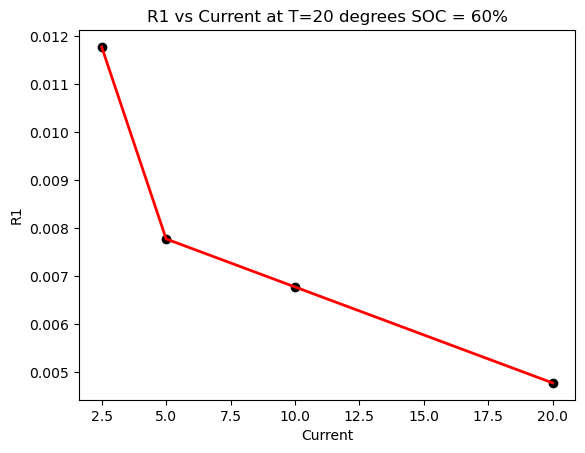

In [22]:
plot_R1_I(1,3,R1_T20_matrix)

##### G. The mathematical function that best represents the physics between R1 and current is a Gaussian function. Fit R1 for 20oC and 60% SOC to a first order Gaussian function as a function of current, and comment on the fit. 

In [23]:
from scipy.optimize import curve_fit

def R1_Gaussian(I, R1_0, b, c, offset):
    return R1_0 * np.exp(-((I - b) ** 2) / c) + offset


# Function to plot R1 data for a given T and SOC, with Gaussian fitted with params
def plot_R1_Gaussian(func,T,SOC,R1_matrix, params):
    curr_array = np.linspace(0,20,10)
    R1_array = func(curr_array, params[0], params[1], params[2], params[3])
    plt.plot(curr_array, R1_array, color='red', linewidth=2)

    plt.plot(delta_curr[T][SOC], R1_matrix[SOC],  'o', color='black')
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}% manually fitted Gaussian")



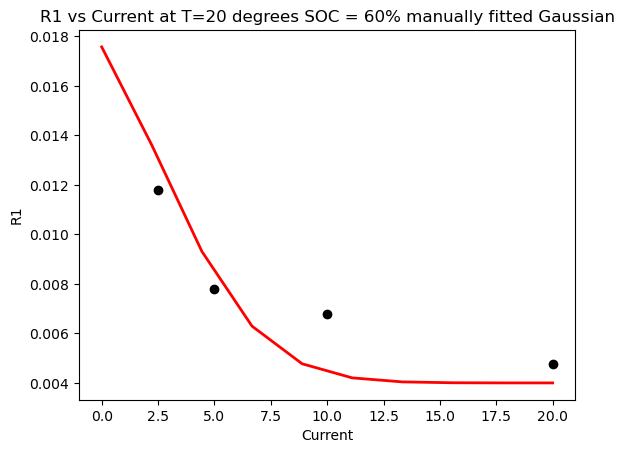

In [24]:
plot_R1_Gaussian(R1_Gaussian, 1,3,R1_T20_matrix, [0.015, -2, 40, 0.004])

##### h. Attempt to improve your fit for R1 by adjusting the fitted equation (this can be done by changing the order or applying an offset).

(Note – you may find that the pulses do not go to small enough currents to enable you to obtain a
Gaussian. You need to use the longer discharge periods, at low current to extract approximate R1
values for smaller currents in discharge.) 

In [25]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# This function calculates and plots the best fit Gaussian line
def fit_R1_Gaussian(func,T,SOC, R1_matrix, p0 = [0.01, 1, 30, 0.004]):

    I = delta_curr[T][SOC].tolist()
    r1_vals = R1_matrix[SOC].tolist()
    p0 = [0.01, 1, 30, 0.004] # initial params
    params, pcov = curve_fit(func, I, r1_vals, p0=p0, maxfev=10000000)

    I_plotting = np.linspace(0,20,100)
    plt.plot(I, r1_vals, 'o', label='data')
    plt.plot(I_plotting, func(I_plotting, *params), label='fit')
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}% fitted with a Gaussian")
    plt.legend()
    plt.show()
    print('R1_0:', params[0])
    print('b:', params[1])
    print('c:', params[2])
    print("offset", params[3])

    print(params)

    #return params

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


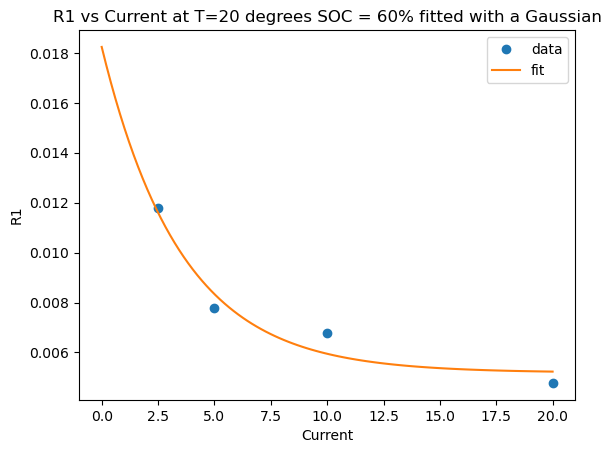

R1_0: 5.3796640598828906e+156
b: -2571.4374243005627
c: 18104.700675160788
offset 0.005190988976485632
[ 5.37966406e+156 -2.57143742e+003  1.81047007e+004  5.19098898e-003]


In [26]:
fit_R1_Gaussian(R1_Gaussian, 1,3, R1_T20_matrix, p0 = [0.15, -2, 40, 0.04])

- I'm not sure if these parameters make sense

#### Part 2.A Discussion

1. Comment on the advantages and disadvantages of the three approaches to the interpolation
problem described above, and any other approaches of which you can think. 


2. What assumptions about the physical mechanisms inside a battery are you making by keeping R0 constant?

3. Plot the value of R0 as a function of current at 60% SOC and comment on how accurate this
assumption is.

Text(0.5, 1.0, 'R0 vs Current at T=20degrees SOC = 60%')

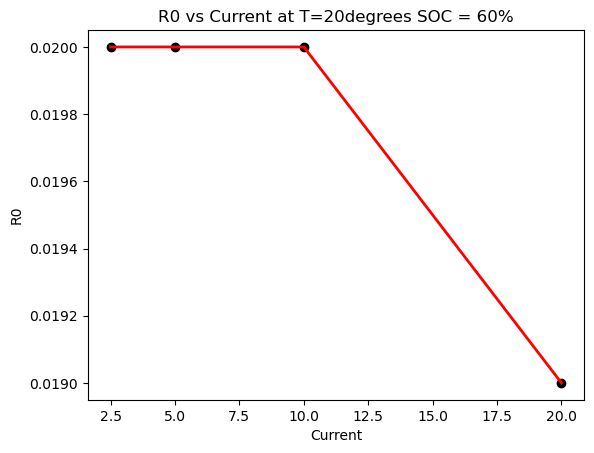

In [27]:
# Plot the point
r0_plot = r0_20_60 = R0_matrix[1][3]
current_plot = delta_curr[1][3]
plt.plot(current_plot, r0_plot,  'o', color='black')


# Also plot a fitted line
coefficients = np.polyfit(current_plot,r0_plot,3)
line = np.polyval(coefficients, current_plot)

plt.plot(delta_curr[0][3], line, color='red', linewidth=2)

plt.xlabel("Current")
plt.ylabel("R0")
plt.grid
plt.title("R0 vs Current at T=20degrees SOC = 60%")


The assumption of constant R0 with current seems reasonable for the first three datapoints, but not the last. So when current increases by very much R0 decreases slightly.

4. What assumptions regarding battery mechanisms are you making by keeping C1 constant? 

5. Plot the value of C1 as a function of current at 60% SOC and comment on how accurate this
assumption is. 

Text(0.5, 1.0, 'R0 vs Current at T=20degrees SOC = 60%')

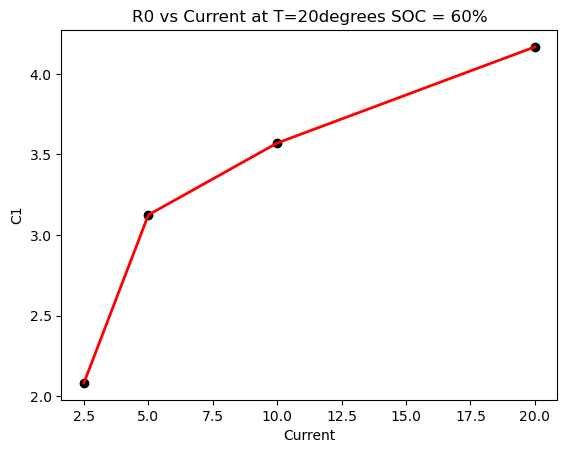

In [28]:
# Plot the point
c1_plot = c1_20_60 = C1_matrix[1][3]
current_plot = delta_curr[1][3]
plt.plot(current_plot, c1_plot,  'o', color='black')


# Also plot a fitted line
coefficients = np.polyfit(current_plot,c1_plot,3)
line = np.polyval(coefficients, current_plot)

plt.plot(delta_curr[0][3], line, color='red', linewidth=2)

plt.xlabel("Current")
plt.ylabel("C1")
plt.grid
plt.title("R0 vs Current at T=20degrees SOC = 60%")


I think my capacitance values are false so I can not yet make a comment

## Part 2B: Temperature Dependence of R0

#### Part 2B Questions

##### A. Repeat steps a-g from part 2a for the data given at 0oC and 40oC, but  using the value of C1 at 20oC as a constant throughout. 


Steps A,B already done
Steps C,D,E done below

In [29]:
# A,B

# C. Take average values of R0
# T=0
R0_T0 = R0_matrix[0].mean()
print("Mean value of R0 at 0 degrees: ", R0_T0)

# T=40
R0_T40 = R0_matrix[2].mean()
print("Mean value of R0 at 40 degrees: ", R0_T40)

# D. use same C1
C1_T0 = C1_T20
C1_T40 = C1_T20


# E.

# Calculate R1 using constant R0
# T=0
R1_T0_ConstantR0_array = v_settling_changes[0]/delta_curr[0] - R0_T0
R1_T0_ConstantR0 = R1_T0_ConstantR0_array.mean()
print("Mean R1 we get using constant R0 for T = 0 is : " , R1_T0_ConstantR0)

# T=40
R1_T40_ConstantR0_array = v_settling_changes[2]/delta_curr[2] - R0_T40
R1_T40_ConstantR0 = R1_T40_ConstantR0_array.mean()
print(" Mean R1 we get using constant R0 for T = 40 is : " , R1_T40_ConstantR0)


# Calculate R1 using constant C1
# T=0
R1_T0_ConstantC1_array = t_settling_times[0]/4/C1_T0
R1_T0_ConstantC1 = R1_T0_ConstantC1_array.mean()
print(" Mean R1 we get using constant C1 at T=0  is : " , R1_T0_ConstantC1)

# T=40 
R1_T40_ConstantC1_array = t_settling_times[2]/4/C1_T40
R1_T40_ConstantC1 = R1_T40_ConstantC1_array.mean()
print(" Mean R1 we get using constant C1 at T=40 is : " , R1_T40_ConstantC1)

# Take Average of these for R1
# T=0
R1_T0 = (R1_T0_ConstantC1 + R1_T0_ConstantR0 ) / 2
print("Mean R1 value for T=0 is " , R1_T0)

# T=40
R1_T40 = (R1_T40_ConstantC1 + R1_T40_ConstantR0 ) / 2
print("Mean R1 value for T=40 is " , R1_T40)

# Average these to get R1 matrices
 
R1_T0_matrix = (R1_T0_ConstantC1_array + R1_T0_ConstantR0_array) / 2
R1_T40_matrix = (R1_T40_ConstantC1_array + R1_T40_ConstantR0_array) / 2


Mean value of R0 at 0 degrees:  0.04003214179698077
Mean value of R0 at 40 degrees:  0.015232532035267449
Mean R1 we get using constant R0 for T = 0 is :  0.016292024718560668
 Mean R1 we get using constant R0 for T = 40 is :  0.006187216620631231
 Mean R1 we get using constant C1 at T=0  is :  0.10960446119779901
 Mean R1 we get using constant C1 at T=40 is :  0.05443194525701506
Mean R1 value for T=0 is  0.06294824295817984
Mean R1 value for T=40 is  0.030309580938823143


##### A-F. Plotting R1 against current at SOC 60% 

At T=0

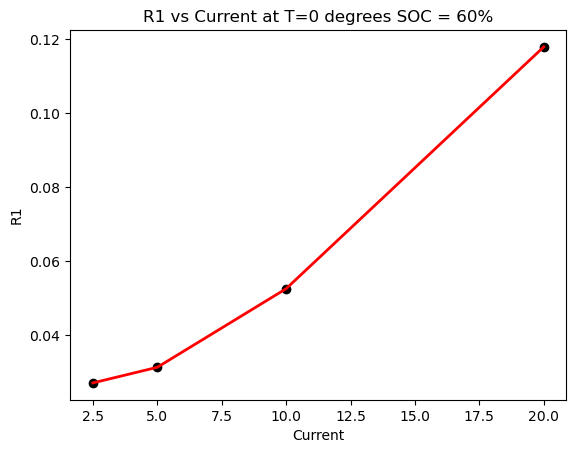

In [30]:
plot_R1_I(0, 3, R1_T0_matrix)

At T=40

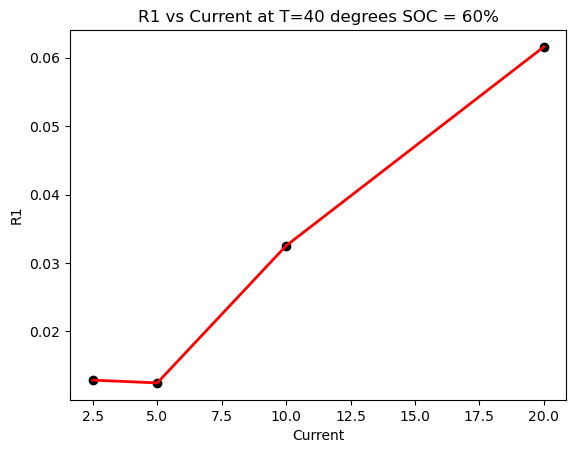

In [31]:
plot_R1_I(2, 3, R1_T40_matrix)

##### A-G. Plot the Gaussian by manually fitting the parameters

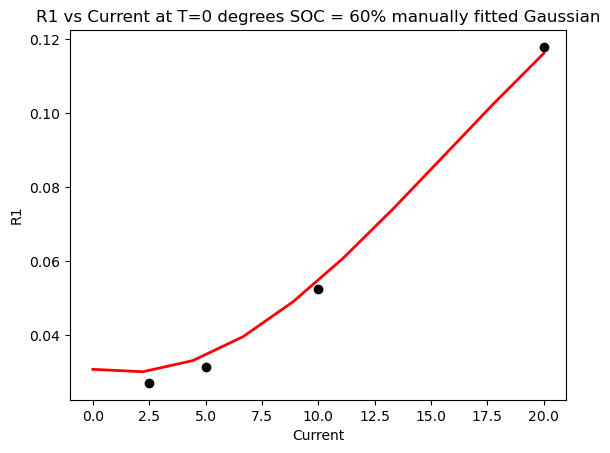

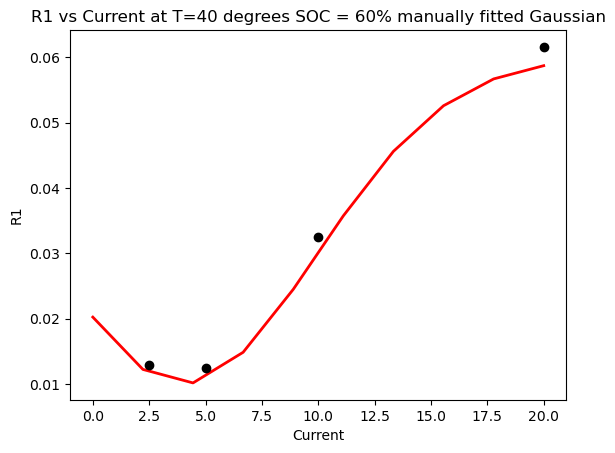

In [32]:
plot_R1_Gaussian(R1_Gaussian, 0,3,R1_T0_matrix, [-0.15, 1.5, 400, 0.18])
plt.show()
plot_R1_Gaussian(R1_Gaussian, 2,3,R1_T40_matrix, [-0.05, 4, 70, 0.06])
plt.show()

##### A-H. Fit the Gaussian properly using curve fitting

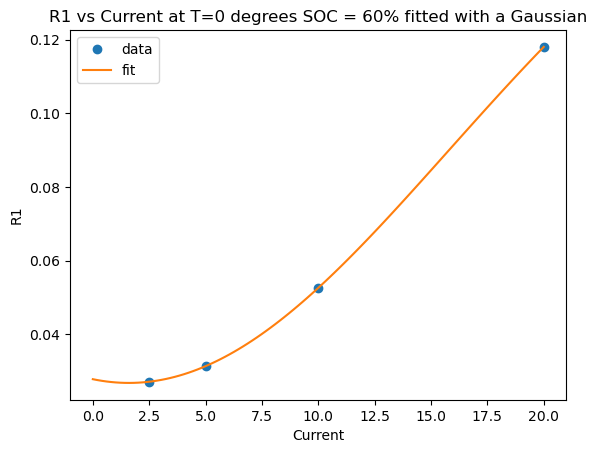

R1_0: -0.16013514782968802
b: 1.5975088718465578
c: 402.14344239249255
offset 0.18698124986336093
[-1.60135148e-01  1.59750887e+00  4.02143442e+02  1.86981250e-01]


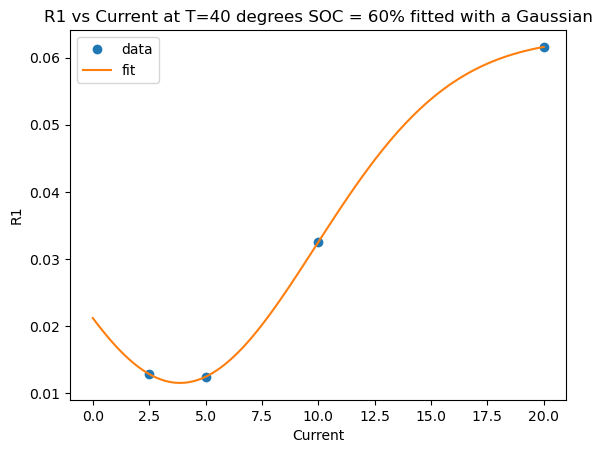

R1_0: -0.05139033339578228
b: 3.865821907352653
c: 71.80382972621716
offset 0.06294845950728639
[-5.13903334e-02  3.86582191e+00  7.18038297e+01  6.29484595e-02]


In [33]:
fit_R1_Gaussian(R1_Gaussian, 0,3, R1_T0_matrix, p0 = [0.15, 1, 400, 0.04])
plt.show()
fit_R1_Gaussian(R1_Gaussian, 2,3, R1_T40_matrix, p0 = [0.15, 3, 40, 0.04])
plt.show()

##### B.Plot the value of R0 (averaged over current) as a function of temperature at 60% SOC and describe its shape. 

Text(0.5, 1.0, 'R0 vs Temperature at SOC = 60%')

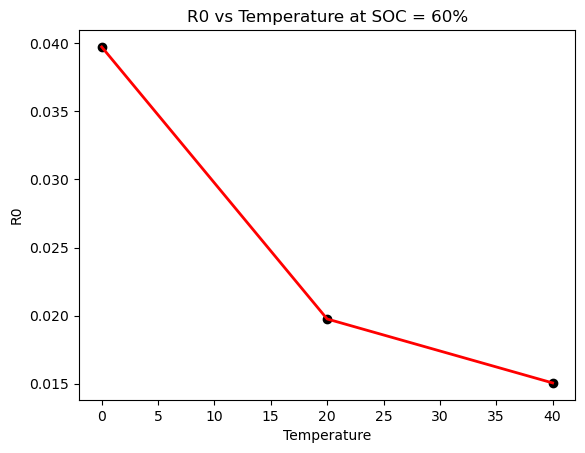

In [34]:
# Get average R0 values at 60% SOC for each temperature
R0_averaged = [R0_matrix[0][3].mean(), R0_matrix[1][3].mean(),  R0_matrix[2][3].mean()]

# Plot points and a line
plt.plot([0,20,40], R0_averaged, 'o', color='black')
plt.plot([0,20,40], R0_averaged, color='red', linewidth=2)
plt.xlabel("Temperature")
plt.ylabel("R0")
plt.title("R0 vs Temperature at SOC = 60%")

- R0 decreases with increasing Tempearture

##### C. Fit the R0 from (b) above to the Arrhenius equation as a function of temperature

In [35]:
# define arrhenius function
# note that R0_averaged[1] is the R0 value at 20 degrees i.e. a constant
def R0_Arrhenius(T,E):
    R_gas = 8.3144598
    return  R0_averaged[1]* np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15)) 

# Function to fit Arrgenius curve - input the parameter and SOC name as well 
def fit_Arrhenius(func,R_vals,param_name,SOC):
    p = [-2000] # initial params
    params, pcov = curve_fit(func,[0,20,40], R_vals, p0=p, maxfev=10000000)

    T_plotting = np.linspace(0,40,100)
    plt.plot([0,20,40], R_vals, 'o', label='data')
    plt.plot(T_plotting, func(T_plotting, *params), label='fit')
    plt.xlabel("Temperature")
    plt.ylabel(f"{param_name}")
    plt.title(f"{param_name} vs Temperature at SOC = {SOC}%")


    return params

array([-22413.36807909])

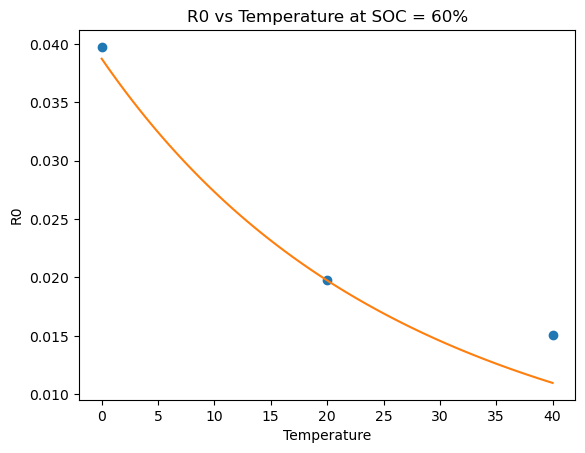

In [36]:
R0_Arrhenius_params = fit_Arrhenius(R0_Arrhenius,R0_averaged,"R0","60")
R0_Arrhenius_params

##### 2.B Discussion
1. How much does R0 vary with temperature?
- Decreases with increasing temperature

2. What physical process does R0 represent?
- Electrolyte resistance

3. Explain why R0 varies in this way with temperature




### Part 2.C : Temperature Dependance of R1
Parametrisation : R1 is a function of current, temperature and SOC



##### A. Plot the value for R1 at 0°C and -2.5A as a function of SOC

Text(0.5, 1.0, 'R1 vs SOC at T=0')

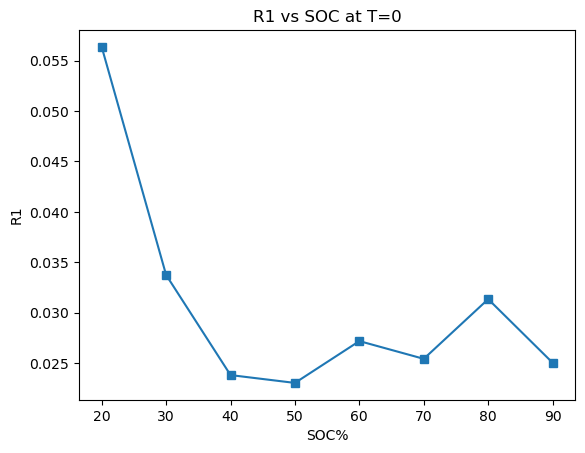

In [37]:
socs = np.linspace(90,20,8)
plt.plot(socs, R1_T0_matrix[:,0], marker= "s")
plt.xlabel("SOC%")
plt.ylabel("R1")
plt.title("R1 vs SOC at T=0")

##### B. Comment on R1 dependency on SOC 

R1 increases with decreasing SOC after about SOC = 40, before that it is roughly constant, our data is noisy so its fluctuating a little

For simplicity, from here on, you will ignore the R1 dependence on SOC. To continue parametrising your model, complete the following steps:

##### C. Plot the value of R1 at 60% SOC and -2.5A as a function of temperature. 

Text(0.5, 1.0, 'R1 vs T at SOC=60%')

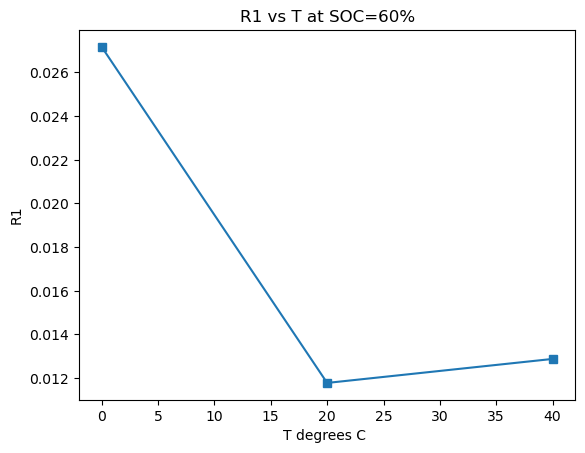

In [38]:
temps = np.linspace(0,40,3)
# Get R1 values at SOC=60% I = -2.5 for each temperature : index [3,0]
r_vals = [R1_T0_matrix[3,0], R1_T20_matrix[3,0], R1_T40_matrix[3,0]]

plt.plot(temps, r_vals, marker= "s")
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=60%")

d. For the data plotted in c., fit R1 to the Arrhenius equation to obtain R1 as a function of
temperature. 

In [39]:
def R1_Arrhenius(T,E):
    R_gas = 8.3144598
    # R1_T20_matrix[3,0] is a constant, R1 value at 20 degrees, I = -2.5, SOC = 60%
    return  R1_T20_matrix[3,0]* np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15))


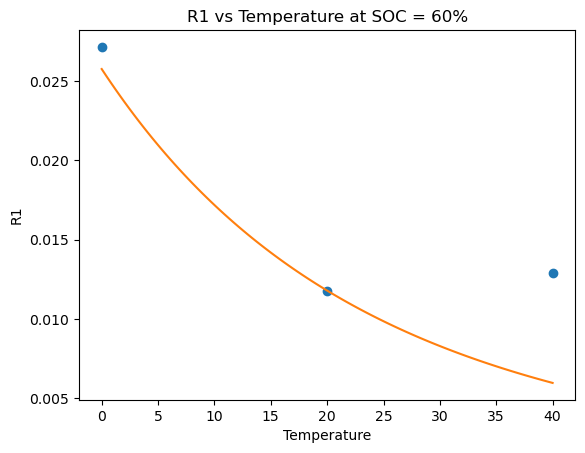

In [40]:
# store fitted E value for later use
E = fit_Arrhenius(R1_Arrhenius,r_vals,"R1","60")


!!! Maybe our third R0 data is faulty? 

##### E. Plot the value of R1 at -2.5A as a function of temperature, at 30% SOC and 90% separately

##### F. On each of the two plots in e., overlay the Arrhenius equation using the values of R1 20oC for that SOC, and the value of E as parametrised at 60%.

In [41]:
print(E[0]) # this is the E value found at SOC = 60%

-26060.045439328256


SOC=90%

Text(0.5, 1.0, 'R1 vs T at SOC=90%')

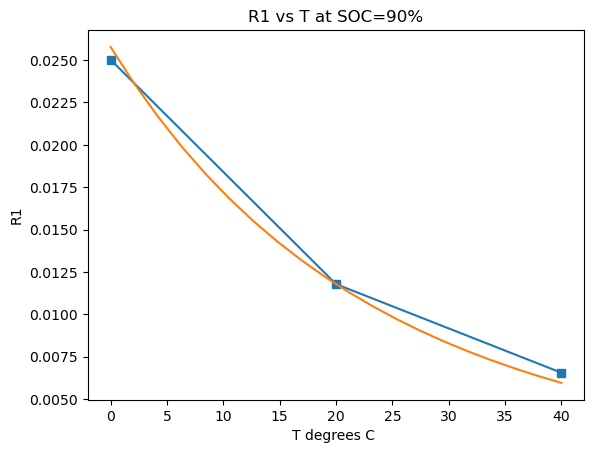

In [42]:
# Get R1 values at SOC=90% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[0,0], R1_T20_matrix[0,0], R1_T40_matrix[0,0]]
plt.plot([0,20,40], r_vals, marker= "s")

# Plot the fitted lien using arrhenius and the E value found above
temps = np.linspace(0,40,20)
r_vals_predicted = R1_Arrhenius(temps, E[0])
plt.plot(temps, r_vals_predicted)
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=90%")

SOC= 30%

Text(0.5, 1.0, 'R1 vs T at SOC=30%')

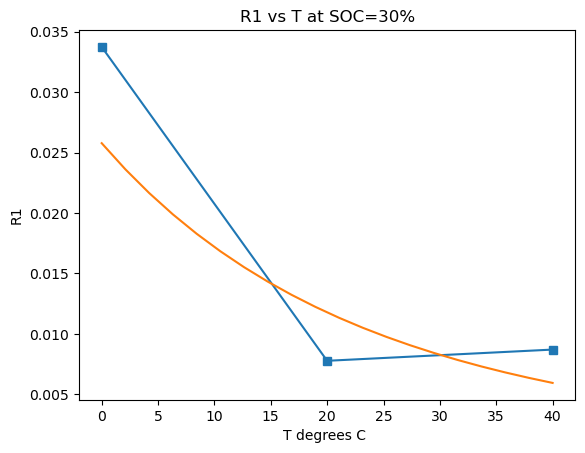

In [43]:
# Get R1 values at SOC=30% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[6,0], R1_T20_matrix[6,0], R1_T40_matrix[6,0]]
plt.plot( [0,20,40], r_vals, marker= "s")

# Plot the fitted lien using arrhenius and the E value found above
temps = np.linspace(0,40,20)
r_vals_predicted = R1_Arrhenius(temps, E[0])
plt.plot(temps, r_vals_predicted)
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=30%")


##### Discussion
1. Discuss how accurate the Arrhenius equation with the same exponential factor is at predicting the behaviour of R1 at different SOCs.

- The same exponential factor does not fit the R1s at different SOCs very well, it visibly underestimates R1 at SOC=30%. We can get a much more accurate fit if we get the E value for each SOC as such:

Text(0.5, 1.0, 'R1 vs Temp at SOC=90% - with E values fitted for SOC = 90%')

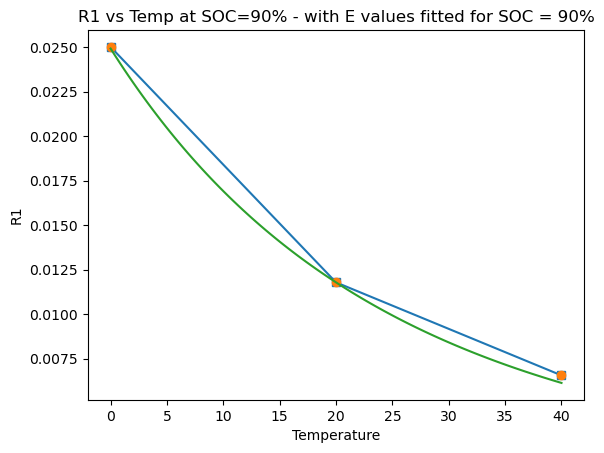

In [44]:
# Get R1 values at SOC=90% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[0,0], R1_T20_matrix[0,0], R1_T40_matrix[0,0]]
plt.plot([0,20,40], r_vals, marker= "s")

fit_Arrhenius(R1_Arrhenius,r_vals,"R1","90")
plt.title("R1 vs Temp at SOC=90% - with E values fitted for SOC = 90%")

Text(0.5, 1.0, 'R1 vs Temp at SOC=30% - with E values fitted for SOC = 30%')

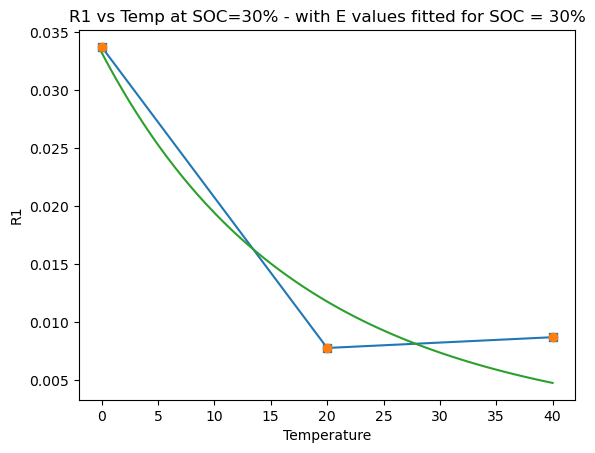

In [45]:
# Get R1 values at SOC=30% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[6,0], R1_T20_matrix[6,0], R1_T40_matrix[6,0]]
plt.plot( [0,20,40], r_vals, marker= "s")

fit_Arrhenius(R1_Arrhenius,r_vals,"R1","90")
plt.title("R1 vs Temp at SOC=30% - with E values fitted for SOC = 30%")


2. Do you think the temperature dependence of C1 is needed for the model to be accurate? 
- I'm not sure how to answer this YET

#### Parametrisation
You can now combine these functions to create a new function for R1 that includes both the current
and temperature dependence: 

Define the function with all 5 parameters

In [46]:
def new_R1_equation(x, R1_0A_T20, b, c, E):
    I, T = x.reshape((2, -1))
    R_gas = 8.3144598
    return R1_0A_T20 * np.exp(-((I-b)**2)/c) * np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15))

Create the arrays for the current and temperature, and the real R1 values to fit

In [47]:
R1_T_I_matrix = np.array([R1_T0_matrix.mean(axis=0), 
                 R1_T20_matrix.mean(axis=0), 
                 R1_T40_matrix.mean(axis=0)])

T_matrix = np.array([[0,0,0,0],
               [20,20,20,20],
               [40,40,40,40]])

I_matrix = np.array([[2.5,5,10,20],
                    [2.5,5,10,20],
                    [2.5,5,10,20]])


# Reshape R1_T_I_matrix to a flattened array
ydata = R1_T_I_matrix.flatten()

# Reshape I_matrix and T_matrix to a flattened array
xdata = np.array([I_matrix.flatten(), T_matrix.flatten()])



In [48]:
xdata.shape

(2, 12)

Fit the function parameters

In [49]:
# Create the initial guess for the parameters
p0 = [0.01, 1, 30, 1]


# Fit the function to the data
params, pcov = curve_fit(new_R1_equation, xdata, ydata, p0=p0)

R1_Gaussian_params = params

# Print the fitted parameters
print("R1_0A_T20 = ", params[0])
print("b = ", params[1])
print("c = ", params[2])
print("E = ", params[3])


R1_0A_T20 =  0.059047575957814895
b =  33.1241921334198
c =  599.2064588220394
E =  -30337.687412876963


Predict R1 using our equation

In [50]:
R1_T_I_predicted_matrix  = new_R1_equation(xdata,*params).reshape((3,4))
R1_T_I_predicted_matrix

array([[0.03070911, 0.0392389 , 0.06017783, 0.11019414],
       [0.01234443, 0.01577323, 0.02419025, 0.04429577],
       [0.00557483, 0.0071233 , 0.01092448, 0.02000428]])

Plot R against I for each temperature

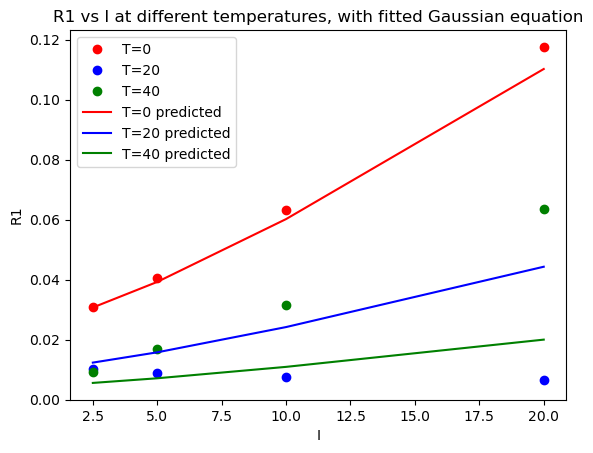

In [51]:
# Plot Real R1 values
plt.plot(I_matrix[0,:], R1_T_I_matrix[0,:],"o", c="r",label="T=0")
plt.plot(I_matrix[1,:], R1_T_I_matrix[1,:], "o", c="b",label="T=20")
plt.plot(I_matrix[2,:], R1_T_I_matrix[2,:], "o", c="g",label="T=40")

# Plot fitted curves
plt.plot(I_matrix[0,:], R1_T_I_predicted_matrix[0,:], c="r", label="T=0 predicted")
plt.plot(I_matrix[1,:], R1_T_I_predicted_matrix[1,:], c="b",label="T=20 predicted")
plt.plot(I_matrix[2,:], R1_T_I_predicted_matrix[2,:],  c="g",label="T=40 predicted")

plt.xlabel("I")
plt.ylabel("R1")
plt.title("R1 vs I at different temperatures, with fitted Gaussian equation")
plt.legend()


SO to summarise
- I have R0 as a function of temperature: 
        - R0_Arrhenius(T,E), E is stored in R0_Arrhenius_params
- I have R1 as a function of current and temperature
        - new_R1_equation(x, R1_0A_T20, b, c, E) : x is a 2,12 matrix of Current and Temperatures, parameters are stored in  R1_Gaussian_Params
- I have C1 as a constant
        - Stored in  C1_T0,C1_T20,C1_T40 : all are the same
 

### Part 2.D : Implementation


In [52]:
df_test = pd.read_csv("Data\Battery_Testing_Data.csv")
ocv_data = pd.read_csv("Data\SOC_OCV_MFCTT_2019.csv",sep = "\t")

Current = np.array(df_test["Current (mA)"][1:].reset_index(drop=True))/1000
Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))
Temp = np.array(df_test["Temperature"][1:].reset_index(drop=True))
Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))


df_test.head()


,Time (s),Current (mA),Voltage (V),Temperature
0,NaN,NaN,NaN,NaN
1,1.0,0.0,4.05,21.96
2,2.0,0.0,4.05,21.94
3,3.0,0.0,4.05,21.94
4,4.0,0.0,4.05,21.93


##### Model

Potential error sources:
- C1 is not accurately calculated
- I may have messed up the sign that the current takes in some functions


In [81]:
from scipy.interpolate import interp1d

# Set parameters
R0_func = R0_Arrhenius
R1_func = new_R1_equation
R0_params = R0_Arrhenius_params
R1_params = R1_Gaussian_params
C = C1_T0 
# For some reason my calculations take I as the opposite sign, so multiply by -1
#Current = np.array(df_test["Current (mA)"][1:].reset_index(drop=True))/1000 * -1


n = len(Current) # size of all our arrays


dt = Time[1] - Time[0]

# Calculate R0
R0 = R0_func(Temp, *R0_params)

# Calculate R1
xdata = np.array([Current, Temp])
R1 = np.array(R1_func(xdata, *R1_params))
#R1 = np.floor(R1/0.001) * 0.001

# Calculate current R1
Current_R1 = np.zeros(n)

for i in range(n-1):
    Current_R1[i+1] = np.exp(-dt/(R1[i]*C)) * Current_R1[i] + (1-np.exp(-dt/(R1[i]*C))) * Current[i]


# Calculate state of charge SOC (called z)
z_start = 86
z = np.zeros(n)
z[0] = z_start
for i in range(n-1):
    z[i+1] = z[i] + Current[i]*dt/(2.5*60*60)*100

z = np.round(z,2)

# Calculate OCV by interpolating from the OCV data
# drop duplicates so interpolation works
duplicates = ocv_data.duplicated(subset=['SOC'])
ocv_data = ocv_data.drop_duplicates(subset=['SOC'])


ocv_interpolation = interp1d(ocv_data['SOC'], ocv_data['Ecell/V'], kind='cubic')
ocv = ocv_interpolation(z)

# Calculate voltage #v(t) = OCV(z(t)) - R1 * i_r1(t) - R0 * i(t)
# my currents are negative I think so I set these to +
v_model = ocv + R1 * Current_R1 + R0 * Current










In [88]:
# find the index in df_test where the time is 10- max is 23431
start_time = 18000
end_time = 23431
index = np.where(Time == start_time)[0][0]
end_index = np.where(Time == end_time)[0][0]

index
end_index

23430

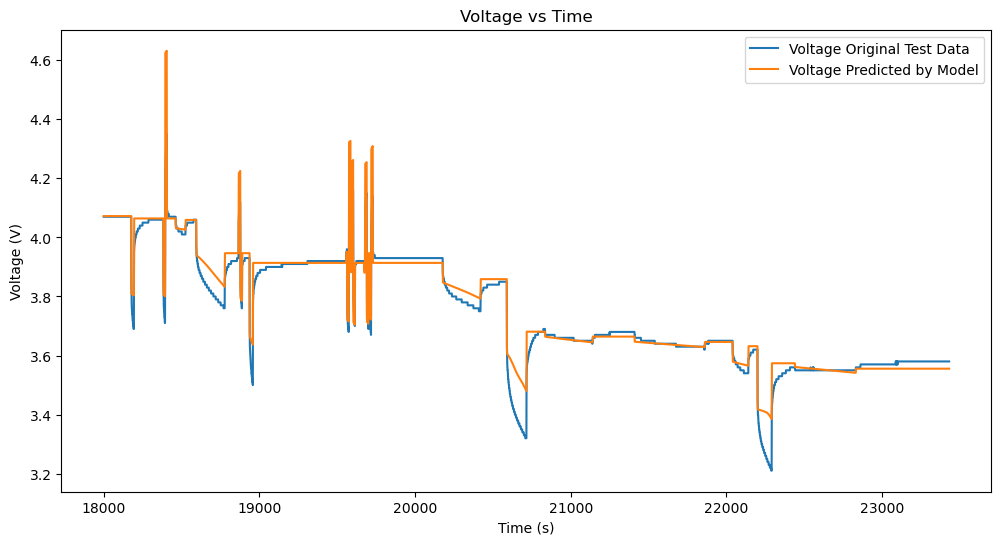

In [89]:
# Plot the Voltage time graph from original data
ax, fig = plt.subplots( figsize=(12, 6))
start_time = 0
plt.plot(Time[index:end_index], Voltage[index:end_index], label="Voltage Original Test Data")
plt.plot(Time[index:end_index], v_model[index:end_index], label="Voltage Predicted by Model")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Time")
plt.legend()


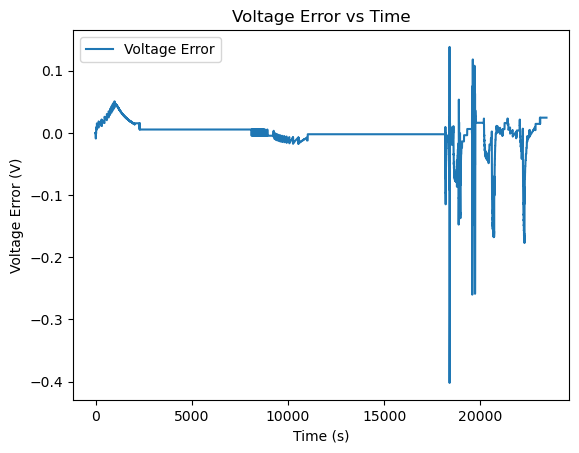

In [90]:
v_error = Voltage - v_model
plt.plot(Time, v_error, label="Voltage Error")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Error (V)")
plt.title("Voltage Error vs Time")
plt.legend()

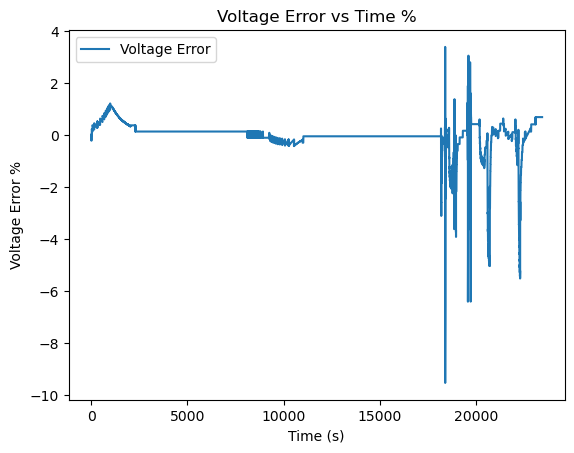

In [92]:
v_error_percentage = (Voltage - v_model)/Voltage*100
plt.plot(Time, v_error_percentage, label="Voltage Error")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Error %")
plt.title("Voltage Error vs Time %")
plt.legend()